**Название проекта**

Построение антифрод модели

_____
**Описание исследования.**

Нам необходимо проанализировать информацию о клиетах с целью написания модели машинного обучения, определяющей мошенник или обычный клиент подает заявление на кредит. Для этого нам необходимо провести предобработку данных, где определимся что делать с пропусками, обработаем колонки и добавим новые в случае необходимости и разберемся с пропусками. Выполним исследовательский анализ данных, посмотрим что из себя представляют наши данные, визуализируем их и попробуем найти возможные закономерности и выбросы. Потом приступим к обучению несколько моделей для определения наиболее подходящей. Как метрику качества будем использовать AUC-ROC. После выбора наилучшей модели проверим ее на тестовой выборке, а так же подведем итог нашего исследования.

_____
**Цель исследования.**
    
Построить предсказательную модель определения мошенничества
   
_____
**Исходные данные.**
    
В нашем распоряжении 4 датасета с информацией о поведении клиентов, полной кредитной истории, данных анкеты и целевой фиче. Так же добавляем справочник регионов.

# Предобработка данных

Загрузим необходимые библиотеки и датасеты.

In [110]:
pip install catboost

In [111]:
! pip install phik

In [112]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import phik

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

In [113]:
pd.options.display.max_columns =  None
pd.options.display.max_rows =  None

К датасетам, что нам дали, добавим справочник регионов, чтобы воспользоваться им при анализе таблицы profile.

In [114]:
behavior = pd.read_csv('/content/drive/MyDrive/Тестовое/behavior_task.csv')
ki = pd.read_csv('/content/drive/MyDrive/Тестовое/ki_loans_task.csv')
profile = pd.read_csv('/content/drive/MyDrive/Тестовое/profile_task.csv')
target = pd.read_csv('/content/drive/MyDrive/Тестовое/target_task.csv')

Сначала рассмотрим наш справочник

In [115]:
region = pd.read_excel('/content/drive/MyDrive/Тестовое/Справочник регионов.xlsx')
region.head()

,Код,Наименование
0,1,Республика Адыгея
1,2,Республика Башкортостан
2,3,Республика Бурятия
3,4,Республика Алтай
4,5,Республика Дагестан


Сделаем функцию для первичного осмотра датасетов и рассмотрим их

In [116]:
def about_data(df):
    print('Первые 5 строк датасета')
    display(df.head())
    print()
    print()
    print('Типы данных')
    print(df.info())
    print()
    print()
    print('Количество пропусков')
    print(df.isna().sum())
    print()
    print()
    print('Количество дубликатов:',df.duplicated().sum())

In [117]:
about_data(behavior)

Первые 5 строк датасета


,ID,SAVE_STAMP,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59
0,19622849,2022-03-01 10:27:26,1.0,NaN,18.0,0.0,2.0,1.0,0.0,0.0,1.0,2.0,NaN,1.0,Mobile Phone,0.0,0.0,0.0,0.0,0.0,2.0,NaN,NaN,0.0,0.0,3.0,1.0,0.0,1.0,0.0,NaN,0.0,0.13,2.0,6.0,1.0,1.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,2.0,1.0,0.0,14.0,4.0,0.194,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,19623228,2022-03-01 10:36:55,0.0,NaN,14.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,3.0,Desktop,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,3.0,1.0,0.0,1.0,0.0,NaN,0.0,0.93,0.0,4.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,2.0,0.0,0.0,24.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,19673010,2022-03-02 16:48:01,0.0,NaN,25.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,3.0,Mobile Phone,1.0,0.0,0.0,0.0,0.0,2.0,NaN,NaN,0.0,0.0,3.0,1.0,0.0,1.0,NaN,1.0,0.0,0.67,0.0,15.0,1.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,5.0,1.0,0.0,117.0,0.0,0.000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,19624134,2022-03-01 11:01:23,0.0,NaN,21.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,NaN,2.0,Mobile Phone,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,5.0,0.0,0.0,1.0,0.0,NaN,0.0,1.00,0.0,7.0,1.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,1.0,1.0,0.0,47.0,0.0,0.092,1.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0
4,19631797,2022-03-01 14:12:59,0.0,NaN,18.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,3.0,Mobile Phone,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,5.0,1.0,1.0,1.0,NaN,2.0,0.0,0.17,0.0,16.0,1.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,1.0,1.0,0.0,75.0,0.0,0.000,1.0,0.0,0.0,0.0,0.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0




Типы данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34215 entries, 0 to 34214
Data columns (total 62 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          34215 non-null  int64  
 1   SAVE_STAMP  34215 non-null  object 
 2   feature_0   33872 non-null  float64
 3   feature_1   0 non-null      float64
 4   feature_2   33829 non-null  float64
 5   feature_3   33872 non-null  float64
 6   feature_4   33872 non-null  float64
 7   feature_5   33872 non-null  float64
 8   feature_6   33860 non-null  float64
 9   feature_7   33859 non-null  float64
 10  feature_8   33829 non-null  float64
 11  feature_9   33872 non-null  float64
 12  feature_10  1519 non-null   object 
 13  feature_11  33872 non-null  float64
 14  feature_12  33845 non-null  object 
 15  feature_13  29403 non-null  float64
 16  feature_14  33872 non-null  float64
 17  feature_15  33872 non-null  float64
 18  feature_16  33872 non-null  float64
 19  feature_17 

У нас достаточно широкая таблица с большим количеством признаков. У многих из них тип флоат, хотя значения целочисленные. Не обошлось и без пропусков в данных, чаще всего фигурирует число 343. Можно удалить 2 дубликата. К списку лишних столбцов еще добавим SAVE_STAMP, так как в датасете с которым мы будем мержить он есть, и перейдем к изучению следующего датасета.



In [118]:
behavior = behavior.drop(labels = ['feature_1', 'feature_19', 'feature_35', 'SAVE_STAMP'], axis = 1)
behavior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34215 entries, 0 to 34214
Data columns (total 58 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          34215 non-null  int64  
 1   feature_0   33872 non-null  float64
 2   feature_2   33829 non-null  float64
 3   feature_3   33872 non-null  float64
 4   feature_4   33872 non-null  float64
 5   feature_5   33872 non-null  float64
 6   feature_6   33860 non-null  float64
 7   feature_7   33859 non-null  float64
 8   feature_8   33829 non-null  float64
 9   feature_9   33872 non-null  float64
 10  feature_10  1519 non-null   object 
 11  feature_11  33872 non-null  float64
 12  feature_12  33845 non-null  object 
 13  feature_13  29403 non-null  float64
 14  feature_14  33872 non-null  float64
 15  feature_15  33872 non-null  float64
 16  feature_16  33872 non-null  float64
 17  feature_17  33872 non-null  float64
 18  feature_18  33872 non-null  float64
 19  feature_20  10018 non-nul

Теперь перейдем к датасету с кредитными историями

In [119]:
about_data(ki)

Первые 5 строк датасета


,ID,SAVE_STAMP,CRED_TYPE,CRED_ACTIVE,CRED_ENDDATE_FACT,CRED_DATE,CRED_OWNER,CRED_SUM_LIMIT,LOAN_AMOUNT_START,DELAY5,DELAY30,DELAY60,DELAY90,DELAY_MORE,CRED_SUM_OVERDUE
0,19634661,2022-03-01 15:27:44,3,13,2018-06-19,2016-12-19,1,2177720,22000,0,0,0,0,0,0
1,19634661,2022-03-01 15:27:44,4,13,2012-09-05,2012-06-07,1,90000,22000,0,0,0,0,0,0
2,19634661,2022-03-01 15:27:44,4,13,2014-06-02,2012-10-05,1,100000,22000,0,0,0,0,0,0
3,19634661,2022-03-01 15:27:44,5,13,2016-04-05,2014-04-07,1,500000,22000,0,0,0,0,0,0
4,19634661,2022-03-01 15:27:44,5,13,2020-01-01,2017-09-08,1,1500000,22000,0,0,0,0,0,0




Типы данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523811 entries, 0 to 523810
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   ID                 523811 non-null  int64 
 1   SAVE_STAMP         523811 non-null  object
 2   CRED_TYPE          523811 non-null  int64 
 3   CRED_ACTIVE        523811 non-null  int64 
 4   CRED_ENDDATE_FACT  523132 non-null  object
 5   CRED_DATE          523811 non-null  object
 6   CRED_OWNER         523811 non-null  int64 
 7   CRED_SUM_LIMIT     523811 non-null  int64 
 8   LOAN_AMOUNT_START  523811 non-null  int64 
 9   DELAY5             523811 non-null  int64 
 10  DELAY30            523811 non-null  int64 
 11  DELAY60            523811 non-null  int64 
 12  DELAY90            523811 non-null  int64 
 13  DELAY_MORE         523811 non-null  int64 
 14  CRED_SUM_OVERDUE   523811 non-null  int64 
dtypes: int64(12), object(3)
memory usage: 59.9+ MB
None




Данный датасет содержит кредитную историю клиентов и состоит из 523811 строк. Одному ID может соответствовать несколько строк, так как клиент мог иметь большое количество кредитов. Так же стоит отметить, что в датасете только один столбец имеет пропуски, их 679. Это фактическая дата закрытия займа, следовательно это еще открытые кредиты. Можем создать на основе него бинарный столбец с признаком есть ли открытые кредиты. Датасет имеет 6132 полных дубликата.

Перейдем к следующему датасету.

In [120]:
about_data(profile)

Первые 5 строк датасета


,ID,SAVE_STAMP,BIRTH_DAY,BIRTH_MONTH,BIRTH_YEAR,INCOME,CARD_EXPIRY_DATE,REG_REGION,RES_REGION,PASS_REGION,SIM_REGION,IP_REGION
0,20349194,2022-03-21 16:54:27,23,12,1997,50000.0,2029-06-30 23:59:59,5000000000000,5000000000000,Московская область,Москва и Московская область,Московская область
1,20592853,2022-03-28 20:25:18,4,12,1985,50000.0,2026-08-31 23:59:59,4700000000000,4700000000000,Ленинградская область,Санкт-Петербург и Ленинградская область,Санкт-Петербург
2,20489395,2022-03-25 20:16:57,27,10,1982,70000.0,2023-10-31 23:59:59,5200000000000,5200000000000,Нижегородская область,Нижегородская область,Нижегородская область
3,20305048,2022-03-20 12:02:34,22,3,1998,50000.0,2022-07-31 23:59:59,7700000000000,7700000000000,Москва,Москва и Московская область,Московская область
4,20393147,2022-03-22 23:11:21,23,10,1966,50000.0,2024-01-31 23:59:59,7700000000000,7700000000000,Москва,Москва и Московская область,Московская область




Типы данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34215 entries, 0 to 34214
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                34215 non-null  int64  
 1   SAVE_STAMP        34215 non-null  object 
 2   BIRTH_DAY         34215 non-null  int64  
 3   BIRTH_MONTH       34215 non-null  int64  
 4   BIRTH_YEAR        34215 non-null  int64  
 5   INCOME            34198 non-null  float64
 6   CARD_EXPIRY_DATE  34214 non-null  object 
 7   REG_REGION        34215 non-null  int64  
 8   RES_REGION        34215 non-null  int64  
 9   PASS_REGION       34192 non-null  object 
 10  SIM_REGION        34208 non-null  object 
 11  IP_REGION         33431 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 3.1+ MB
None


Количество пропусков
ID                    0
SAVE_STAMP            0
BIRTH_DAY             0
BIRTH_MONTH           0
BIRTH_YEAR            0
INCOME   

Данный датасет содержит информацию общую информацию о клиенте. Есть пропуски и в этом датасете, больше всего их в столбце с регионом ip. Так же есть 2 дубликата, как и в датасете behavior. Код региона имеет не очень подходящий формат, а дата рождения разбита на 3 столбца.

Сразу приведем код региона в удобный вид

In [121]:
profile['RES_REGION'] = profile['RES_REGION']/100000000000
profile['REG_REGION'] = profile['REG_REGION']/100000000000
profile.head()

,ID,SAVE_STAMP,BIRTH_DAY,BIRTH_MONTH,BIRTH_YEAR,INCOME,CARD_EXPIRY_DATE,REG_REGION,RES_REGION,PASS_REGION,SIM_REGION,IP_REGION
0,20349194,2022-03-21 16:54:27,23,12,1997,50000.0,2029-06-30 23:59:59,50.0,50.0,Московская область,Москва и Московская область,Московская область
1,20592853,2022-03-28 20:25:18,4,12,1985,50000.0,2026-08-31 23:59:59,47.0,47.0,Ленинградская область,Санкт-Петербург и Ленинградская область,Санкт-Петербург
2,20489395,2022-03-25 20:16:57,27,10,1982,70000.0,2023-10-31 23:59:59,52.0,52.0,Нижегородская область,Нижегородская область,Нижегородская область
3,20305048,2022-03-20 12:02:34,22,3,1998,50000.0,2022-07-31 23:59:59,77.0,77.0,Москва,Москва и Московская область,Московская область
4,20393147,2022-03-22 23:11:21,23,10,1966,50000.0,2024-01-31 23:59:59,77.0,77.0,Москва,Москва и Московская область,Московская область


 У нас есть составные наименования регионов, изменим их на простые: Архангельскую область, Московскую область, Республика Крым, Ленинградская область. И сразу заменим во всем датасете Москву и Санкт-Петербург на соответствующие области.

In [122]:
profile['SIM_REGION'] = profile['SIM_REGION']. replace(['Архангельская область и Ненецкий автономный округ',
                                                        'Москва и Московская область',
                                                        'Республика Крым и Севастополь',
                                                        'Санкт-Петербург и Ленинградская область'], ['Архангельская область',
                                                                                                     'Московская область',
                                                                                                     'Республика Крым',
                                                                                                     'Ленинградская область'])


In [123]:
profile = profile. replace(['Москва',
                            'Санкт-Петербург'], ['Московская область',
                                                 'Ленинградская область'])

Соединим наш справочник с целевой таблицей и введем коды регионов.

In [124]:
profile = profile.merge(region, how='left', left_on='PASS_REGION', right_on='Наименование')
profile = profile.rename(columns={'Код': 'pass_region_code'})
profile = profile.drop(labels = ['Наименование'], axis = 1)

profile = profile.merge(region, how='left', left_on='SIM_REGION', right_on='Наименование')
profile = profile.rename(columns={'Код': 'sim_region_code'})

profile = profile.merge(region, how='left', left_on='IP_REGION', right_on='Наименование')
profile = profile.rename(columns={'Код': 'ip_region_code'})

profile.head()

,ID,SAVE_STAMP,BIRTH_DAY,BIRTH_MONTH,BIRTH_YEAR,INCOME,CARD_EXPIRY_DATE,REG_REGION,RES_REGION,PASS_REGION,SIM_REGION,IP_REGION,pass_region_code,sim_region_code,Наименование_x,ip_region_code,Наименование_y
0,20349194,2022-03-21 16:54:27,23,12,1997,50000.0,2029-06-30 23:59:59,50.0,50.0,Московская область,Московская область,Московская область,50.0,50.0,Московская область,50.0,Московская область
1,20592853,2022-03-28 20:25:18,4,12,1985,50000.0,2026-08-31 23:59:59,47.0,47.0,Ленинградская область,Ленинградская область,Ленинградская область,47.0,47.0,Ленинградская область,47.0,Ленинградская область
2,20489395,2022-03-25 20:16:57,27,10,1982,70000.0,2023-10-31 23:59:59,52.0,52.0,Нижегородская область,Нижегородская область,Нижегородская область,52.0,52.0,Нижегородская область,52.0,Нижегородская область
3,20305048,2022-03-20 12:02:34,22,3,1998,50000.0,2022-07-31 23:59:59,77.0,77.0,Московская область,Московская область,Московская область,50.0,50.0,Московская область,50.0,Московская область
4,20393147,2022-03-22 23:11:21,23,10,1966,50000.0,2024-01-31 23:59:59,77.0,77.0,Московская область,Московская область,Московская область,50.0,50.0,Московская область,50.0,Московская область


Удалим лишние столбцы

In [125]:
profile = profile.drop(labels = ['PASS_REGION', 'SIM_REGION', 'IP_REGION', 'Наименование_x', 'Наименование_y'], axis = 1)
profile.head()

,ID,SAVE_STAMP,BIRTH_DAY,BIRTH_MONTH,BIRTH_YEAR,INCOME,CARD_EXPIRY_DATE,REG_REGION,RES_REGION,pass_region_code,sim_region_code,ip_region_code
0,20349194,2022-03-21 16:54:27,23,12,1997,50000.0,2029-06-30 23:59:59,50.0,50.0,50.0,50.0,50.0
1,20592853,2022-03-28 20:25:18,4,12,1985,50000.0,2026-08-31 23:59:59,47.0,47.0,47.0,47.0,47.0
2,20489395,2022-03-25 20:16:57,27,10,1982,70000.0,2023-10-31 23:59:59,52.0,52.0,52.0,52.0,52.0
3,20305048,2022-03-20 12:02:34,22,3,1998,50000.0,2022-07-31 23:59:59,77.0,77.0,50.0,50.0,50.0
4,20393147,2022-03-22 23:11:21,23,10,1966,50000.0,2024-01-31 23:59:59,77.0,77.0,50.0,50.0,50.0


Рассмотрим последний датасет с таргетом.

In [126]:
about_data(target)

Первые 5 строк датасета


,ID,AF1_TARGET
0,19614912,1.0
1,19615682,1.0
2,19623760,0.0
3,19623933,1.0
4,19624038,0.0




Типы данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34215 entries, 0 to 34214
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          34215 non-null  int64  
 1   AF1_TARGET  34215 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 534.7 KB
None


Количество пропусков
ID            0
AF1_TARGET    0
dtype: int64


Количество дубликатов: 2


Датасет с целевой фичей полностью заполнен и содержит столько же строк и дубликатов как и в profile и behavior.

Таким образом, у нас 4 датасета, из них 3 мы можем объединить и рассмотреть подробнее наши заявки. Датасет с кредитной историей гораздо больше и содержит строки с одинаковыми ID, лучше из него сделать некую сводную таблицу и объединить ее с нашим основным датасетом.

Пока объединим 3 датасета без преобразований

In [127]:
data = (target
      .merge(behavior, how="left", on="ID")
      .merge(profile, how="left", on="ID"))

about_data(data)

Первые 5 строк датасета


,ID,AF1_TARGET,feature_0,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,SAVE_STAMP,BIRTH_DAY,BIRTH_MONTH,BIRTH_YEAR,INCOME,CARD_EXPIRY_DATE,REG_REGION,RES_REGION,pass_region_code,sim_region_code,ip_region_code
0,19614912,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,ru-ru,2.0,Mobile Phone,NaN,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,3.0,NaN,0.0,1.0,0.0,NaN,0.0,0.50,0.0,8.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,NaN,1.0,0.0,15.0,1.0,0.174,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2022-03-01 03:09:52,13,6,1980,50000.0,2024-07-31 23:59:59,5.0,5.0,5.0,50.0,5.0
1,19615682,1.0,0.0,12.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,NaN,3.0,Mobile Phone,NaN,0.0,0.0,0.0,0.0,2.0,NaN,1.0,1.0,3.0,0.0,0.0,1.0,0.0,NaN,0.0,0.20,0.0,14.0,1.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,NaN,1.0,0.0,40.0,0.0,0.000,1.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,2022-03-01 04:38:13,13,7,1989,70000.0,2024-12-31 23:59:59,77.0,77.0,50.0,50.0,NaN
2,19623760,0.0,1.0,12.0,1.0,5.0,2.0,0.0,0.0,1.0,0.0,NaN,2.0,Mobile Phone,NaN,0.0,1.0,0.0,0.0,1.0,3.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,NaN,0.0,0.50,0.0,15.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,27.0,11.0,0.000,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,5.0,1.0,1.0,2022-03-01 10:52:15,15,4,1976,70000.0,2025-11-30 23:59:59,2.0,2.0,16.0,16.0,34.0
3,19623933,1.0,0.0,14.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,2.0,Desktop,1.0,0.0,0.0,0.0,0.0,3.0,NaN,0.0,0.0,3.0,1.0,0.0,1.0,0.0,NaN,0.0,0.93,0.0,17.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,8.0,0.0,0.0,13.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-03-01 10:56:41,26,1,1979,100000.0,2024-12-31 23:59:59,78.0,78.0,60.0,38.0,47.0
4,19624038,0.0,1.0,4.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,NaN,5.0,Desktop,NaN,0.0,0.0,0.0,0.0,1.0,3.0,0.0,1.0,3.0,1.0,0.0,1.0,0.0,NaN,0.0,0.50,0.0,7.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,NaN,0.0,0.0,5.0,3.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2022-03-01 10:59:19,20,8,1987,70000.0,2024-04-30 23:59:59,78.0,78.0,47.0,47.0,47.0




Типы данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34227 entries, 0 to 34226
Data columns (total 70 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                34227 non-null  int64  
 1   AF1_TARGET        34227 non-null  float64
 2   feature_0         33884 non-null  float64
 3   feature_2         33841 non-null  float64
 4   feature_3         33884 non-null  float64
 5   feature_4         33884 non-null  float64
 6   feature_5         33884 non-null  float64
 7   feature_6         33872 non-null  float64
 8   feature_7         33871 non-null  float64
 9   feature_8         33841 non-null  float64
 10  feature_9         33884 non-null  float64
 11  feature_10        1519 non-null   object 
 12  feature_11        33884 non-null  float64
 13  feature_12        33857 non-null  object 
 14  feature_13        29415 non-null  float64
 15  feature_14        33884 non-null  float64
 16  feature_15        33884 no

Удалим явные дубликаты и рассмотрим пропуски

In [128]:
data = data.drop_duplicates()

Добавим дату рождения одним столбцом

In [129]:
data['SAVE_STAMP'] = pd.to_datetime(data['SAVE_STAMP'])
data['CARD_EXPIRY_DATE'] = pd.to_datetime(data['CARD_EXPIRY_DATE'])

data['birth'] = data['BIRTH_DAY'].astype('str') + '.' + data['BIRTH_MONTH'].astype('str') + '.' + data['BIRTH_YEAR'].astype('str')
data['birth'] = pd.to_datetime(data['birth'])

<ipython-input-129-f9051b4bdf55>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['SAVE_STAMP'] = pd.to_datetime(data['SAVE_STAMP'])
<ipython-input-129-f9051b4bdf55>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['CARD_EXPIRY_DATE'] = pd.to_datetime(data['CARD_EXPIRY_DATE'])
<ipython-input-129-f9051b4bdf55>:5: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['birth'] = pd.to_dat

Добавим разницу в днях между датой подачи заявления и датой рождения

In [130]:
data['age'] = (data['SAVE_STAMP'] - data['birth']).apply(lambda x: x.days)

Удалим лишние столбцы

In [131]:
data = data.drop(labels = ['BIRTH_DAY', 'BIRTH_MONTH', 'BIRTH_YEAR', 'birth'], axis = 1)
data.head()

,ID,AF1_TARGET,feature_0,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,SAVE_STAMP,INCOME,CARD_EXPIRY_DATE,REG_REGION,RES_REGION,pass_region_code,sim_region_code,ip_region_code,age
0,19614912,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,ru-ru,2.0,Mobile Phone,NaN,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,3.0,NaN,0.0,1.0,0.0,NaN,0.0,0.50,0.0,8.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,NaN,1.0,0.0,15.0,1.0,0.174,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2022-03-01 03:09:52,50000.0,2024-07-31 23:59:59,5.0,5.0,5.0,50.0,5.0,15236
1,19615682,1.0,0.0,12.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,NaN,3.0,Mobile Phone,NaN,0.0,0.0,0.0,0.0,2.0,NaN,1.0,1.0,3.0,0.0,0.0,1.0,0.0,NaN,0.0,0.20,0.0,14.0,1.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,NaN,1.0,0.0,40.0,0.0,0.000,1.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,2022-03-01 04:38:13,70000.0,2024-12-31 23:59:59,77.0,77.0,50.0,50.0,NaN,11919
2,19623760,0.0,1.0,12.0,1.0,5.0,2.0,0.0,0.0,1.0,0.0,NaN,2.0,Mobile Phone,NaN,0.0,1.0,0.0,0.0,1.0,3.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,NaN,0.0,0.50,0.0,15.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,27.0,11.0,0.000,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,5.0,1.0,1.0,2022-03-01 10:52:15,70000.0,2025-11-30 23:59:59,2.0,2.0,16.0,16.0,34.0,16756
3,19623933,1.0,0.0,14.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,2.0,Desktop,1.0,0.0,0.0,0.0,0.0,3.0,NaN,0.0,0.0,3.0,1.0,0.0,1.0,0.0,NaN,0.0,0.93,0.0,17.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,8.0,0.0,0.0,13.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-03-01 10:56:41,100000.0,2024-12-31 23:59:59,78.0,78.0,60.0,38.0,47.0,15740
4,19624038,0.0,1.0,4.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,NaN,5.0,Desktop,NaN,0.0,0.0,0.0,0.0,1.0,3.0,0.0,1.0,3.0,1.0,0.0,1.0,0.0,NaN,0.0,0.50,0.0,7.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,NaN,0.0,0.0,5.0,3.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2022-03-01 10:59:19,70000.0,2024-04-30 23:59:59,78.0,78.0,47.0,47.0,47.0,12612


Рассмотрим датасет с кредитной историей, сделаем на основе него сводные таблицы

In [132]:
ki.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523811 entries, 0 to 523810
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   ID                 523811 non-null  int64 
 1   SAVE_STAMP         523811 non-null  object
 2   CRED_TYPE          523811 non-null  int64 
 3   CRED_ACTIVE        523811 non-null  int64 
 4   CRED_ENDDATE_FACT  523132 non-null  object
 5   CRED_DATE          523811 non-null  object
 6   CRED_OWNER         523811 non-null  int64 
 7   CRED_SUM_LIMIT     523811 non-null  int64 
 8   LOAN_AMOUNT_START  523811 non-null  int64 
 9   DELAY5             523811 non-null  int64 
 10  DELAY30            523811 non-null  int64 
 11  DELAY60            523811 non-null  int64 
 12  DELAY90            523811 non-null  int64 
 13  DELAY_MORE         523811 non-null  int64 
 14  CRED_SUM_OVERDUE   523811 non-null  int64 
dtypes: int64(12), object(3)
memory usage: 59.9+ MB


Сделаем таблицу по количеству кредитов у каждого id

In [133]:
count_credits = ki.pivot_table(
    index='ID', values='CRED_DATE', aggfunc='count'). reset_index()

count_credits.head()

,ID,CRED_DATE
0,19612833,7
1,19612862,11
2,19612871,8
3,19612936,15
4,19613247,20


Посмотрим сумму просроченной задолженности

In [134]:
sum_overdue = ki.pivot_table(
    index='ID', values='CRED_SUM_OVERDUE', aggfunc='sum'). reset_index()
sum_overdue.head()

,ID,CRED_SUM_OVERDUE
0,19612833,0
1,19612862,0
2,19612871,0
3,19612936,263811
4,19613247,0


Сделаем сводную по количеству открытых кредитов

In [135]:
ki['CRED_ENDDATE_FACT'] = ki['CRED_ENDDATE_FACT'].fillna('yes')
ki['open_cred'] = np.where(ki['CRED_ENDDATE_FACT'] == 'yes', 1, 0)
open_cred = ki.loc[ki['open_cred'] == 1]
open_cred = open_cred[['ID', 'open_cred']]
open_cred.head()

,ID,open_cred
325,19633308,1
328,19633308,1
329,19633308,1
331,19633308,1
1307,19630274,1


Теперь смержим наши сводные таблицы с основной

In [136]:
data = data.merge(count_credits, how='left', on='ID')
data = data.rename(columns={'CRED_DATE': 'count_credit'})

data = data.merge(sum_overdue, how='left', on='ID')
data = data.rename(columns={'CRED_SUM_OVERDUE': 'sum_overdue'})

data = data.merge(open_cred, how='left', on='ID')

data.head()

,ID,AF1_TARGET,feature_0,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,SAVE_STAMP,INCOME,CARD_EXPIRY_DATE,REG_REGION,RES_REGION,pass_region_code,sim_region_code,ip_region_code,age,count_credit,sum_overdue,open_cred
0,19614912,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,ru-ru,2.0,Mobile Phone,NaN,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,3.0,NaN,0.0,1.0,0.0,NaN,0.0,0.50,0.0,8.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,NaN,1.0,0.0,15.0,1.0,0.174,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2022-03-01 03:09:52,50000.0,2024-07-31 23:59:59,5.0,5.0,5.0,50.0,5.0,15236,4.0,0.0,NaN
1,19615682,1.0,0.0,12.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,NaN,3.0,Mobile Phone,NaN,0.0,0.0,0.0,0.0,2.0,NaN,1.0,1.0,3.0,0.0,0.0,1.0,0.0,NaN,0.0,0.20,0.0,14.0,1.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,NaN,1.0,0.0,40.0,0.0,0.000,1.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,2022-03-01 04:38:13,70000.0,2024-12-31 23:59:59,77.0,77.0,50.0,50.0,NaN,11919,1.0,0.0,NaN
2,19623760,0.0,1.0,12.0,1.0,5.0,2.0,0.0,0.0,1.0,0.0,NaN,2.0,Mobile Phone,NaN,0.0,1.0,0.0,0.0,1.0,3.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,NaN,0.0,0.50,0.0,15.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,27.0,11.0,0.000,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,5.0,1.0,1.0,2022-03-01 10:52:15,70000.0,2025-11-30 23:59:59,2.0,2.0,16.0,16.0,34.0,16756,11.0,0.0,NaN
3,19623933,1.0,0.0,14.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,2.0,Desktop,1.0,0.0,0.0,0.0,0.0,3.0,NaN,0.0,0.0,3.0,1.0,0.0,1.0,0.0,NaN,0.0,0.93,0.0,17.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,8.0,0.0,0.0,13.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-03-01 10:56:41,100000.0,2024-12-31 23:59:59,78.0,78.0,60.0,38.0,47.0,15740,9.0,0.0,NaN
4,19624038,0.0,1.0,4.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,NaN,5.0,Desktop,NaN,0.0,0.0,0.0,0.0,1.0,3.0,0.0,1.0,3.0,1.0,0.0,1.0,0.0,NaN,0.0,0.50,0.0,7.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,NaN,0.0,0.0,5.0,3.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2022-03-01 10:59:19,70000.0,2024-04-30 23:59:59,78.0,78.0,47.0,47.0,47.0,12612,12.0,301636.0,NaN


Теперь разберемся с пропусками

In [137]:
data.isna().sum()

,0
ID,0
AF1_TARGET,0
feature_0,343
feature_2,386
feature_3,343
feature_4,343
feature_5,343
feature_6,355
feature_7,356
feature_8,386


Пропуски в созданных столбцах на основе кредитной истории заменим нулями и сразу изменим тип на целочисленный

In [138]:
list_colum = ['count_credit', 'sum_overdue', 'open_cred']

for i in list_colum:
  data[i] = data[i].fillna(0).astype('int')

Посмотрим какие уникальные значения есть в столбцах

In [139]:
for i in data.columns:
    print('Графа', i)
    print(data[i].sort_values().unique())

Графа ID
[19612833 19612862 19612871 ... 20707345 20707356 20707380]
Графа AF1_TARGET
[0. 1.]
Графа feature_0
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  12.  13.  15.
  16.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.
  31.  32.  33.  34.  35.  36.  37.  41.  42.  45.  46.  47.  48.  49.
  50.  51.  52.  54.  55.  56.  57.  58.  59.  61.  64.  65.  67.  68.
  69.  70.  75.  76.  77.  78.  79.  80.  81.  82.  83.  85.  88.  91.
  93.  94.  95.  97.  98.  99. 100.  nan]
Графа feature_2
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  53.  54.  55.  56.  57.
  63.  66.  67.  69.  71.  72.  79.  82. 100. 116.  nan]
Графа feature_3
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  12.  13.  15.
  16.  18.  19.  20.  21.  22.  23.  24.  25.  26

Заменим на нули пустые значения в числовых переменных.

In [140]:
list_columns = ['feature_0','feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9',
                'feature_11', 'feature_13','feature_14', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_20',
                'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29',
                'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34', 'feature_36', 'feature_37', 'feature_38','feature_39',
                'feature_40', 'feature_41', 'feature_42', 'feature_43', 'feature_44', 'feature_45', 'feature_46','feature_47', 'feature_48',
                'feature_49', 'feature_50', 'feature_51', 'feature_52', 'feature_53', 'feature_54', 'feature_55', 'feature_56', 'feature_57',
                'feature_58', 'feature_59', 'pass_region_code',  'sim_region_code', 'ip_region_code', 'INCOME']

for i in list_columns:
    data[i] = data[i].fillna(0)

В текстовых переменных заменим пустоту на unknown

In [141]:
list_columns = ['feature_10', 'feature_12', 'CARD_EXPIRY_DATE']

for i in list_columns:
    data[i] = data[i].fillna('unknown')

Перепроверим наличие пропусков

In [143]:
data.isna().sum()

,0
ID,0
AF1_TARGET,0
feature_0,0
feature_2,0
feature_3,0
feature_4,0
feature_5,0
feature_6,0
feature_7,0
feature_8,0


Мы объединили наши датасеты, обработали пропуски, удалили дубликаты. Добавили несколько признаков, которые описывают кредитную историю наших клиентов. Теперь перейдем к анализу данных.

# Исследовательский анализ данных

Начнем исследовательский анализ с визуализации наших данных.

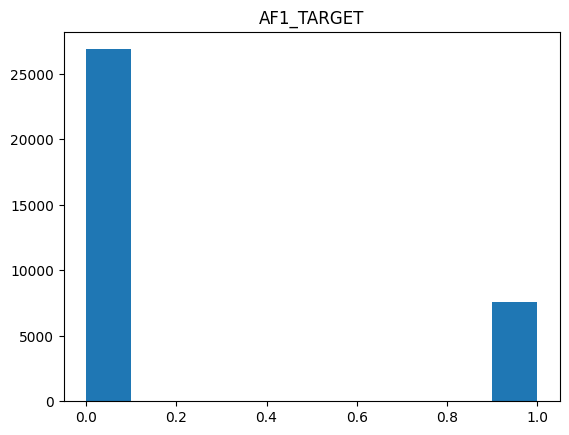

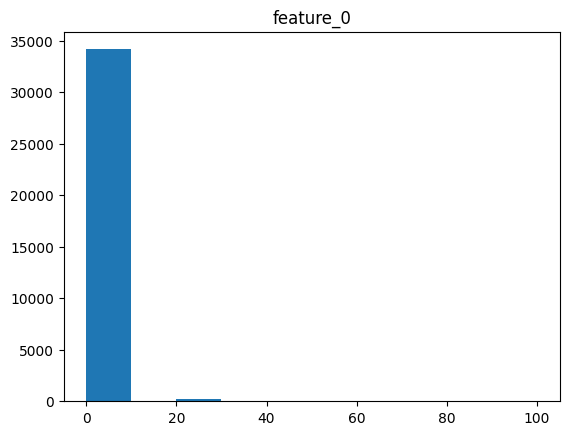

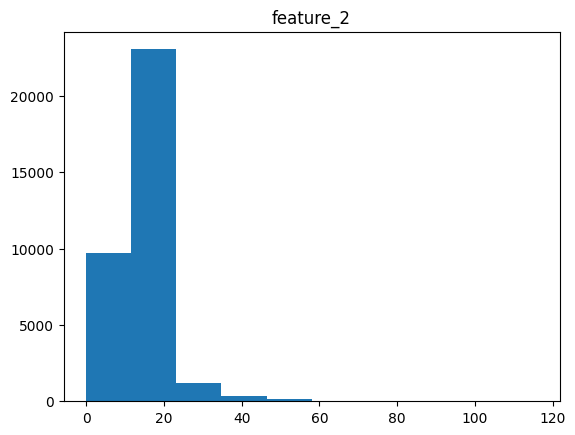

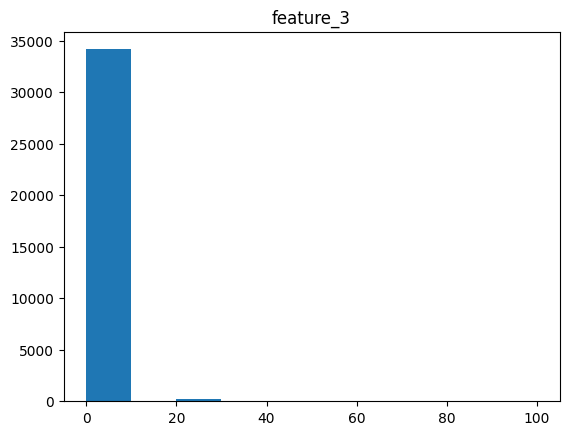

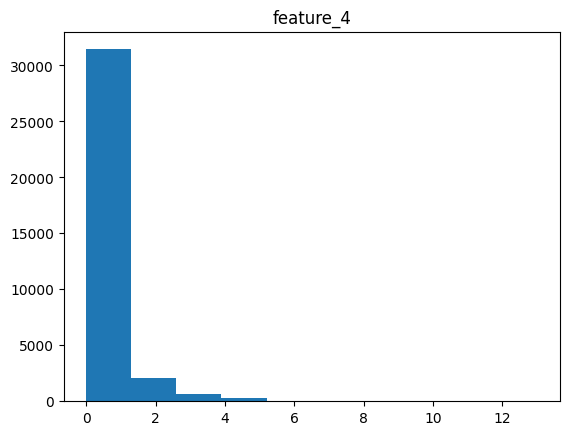

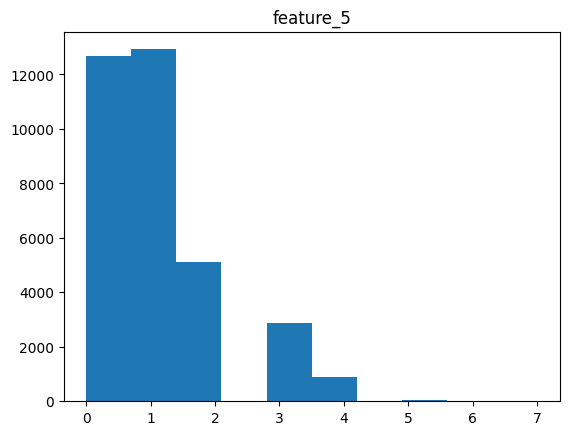

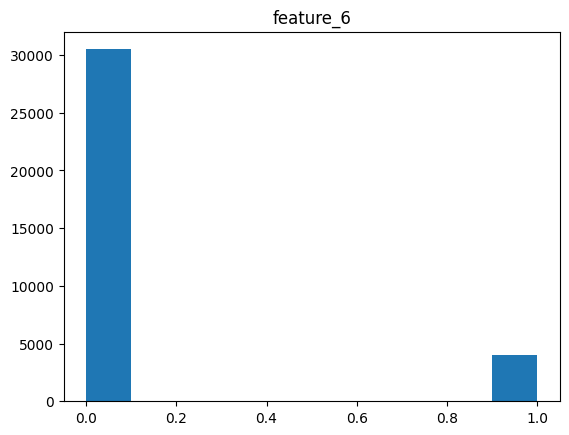

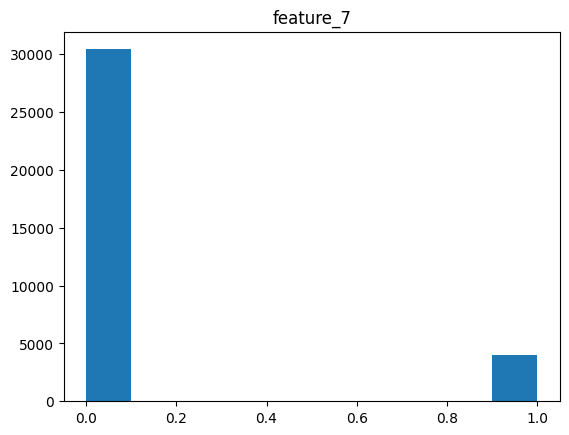

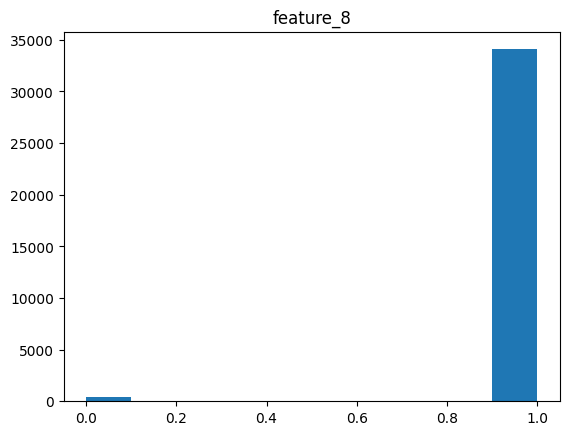

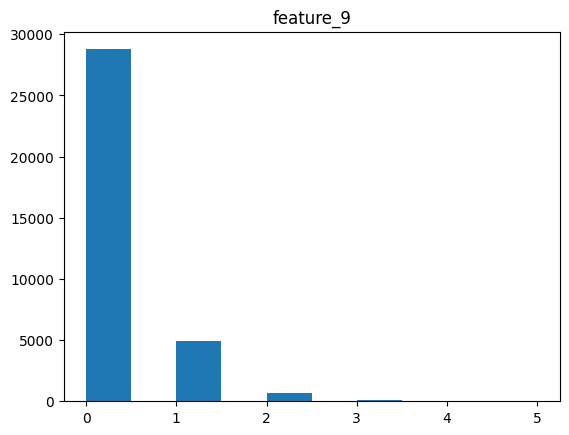

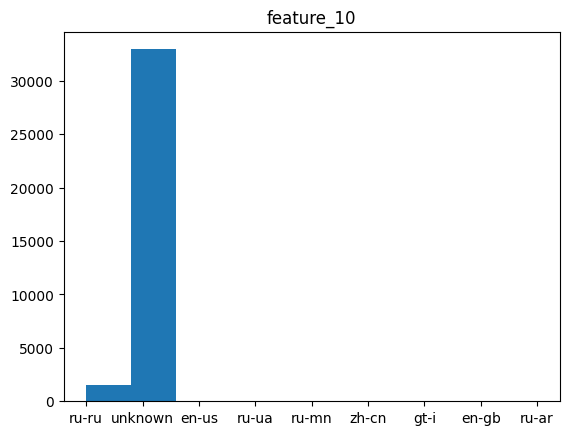

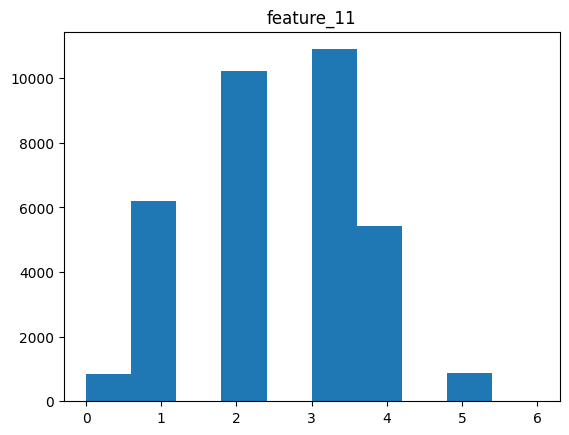

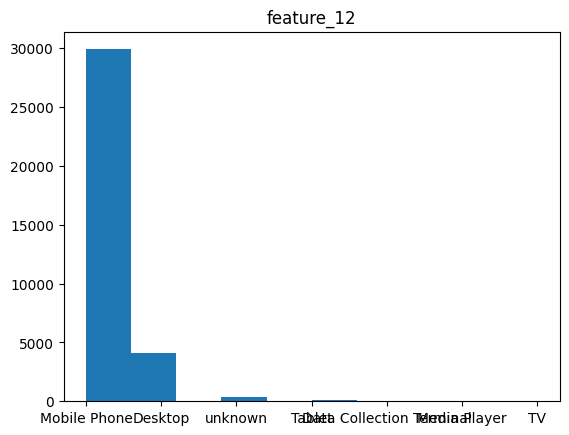

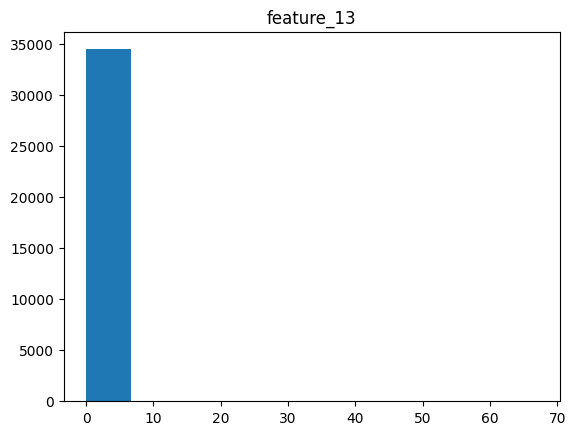

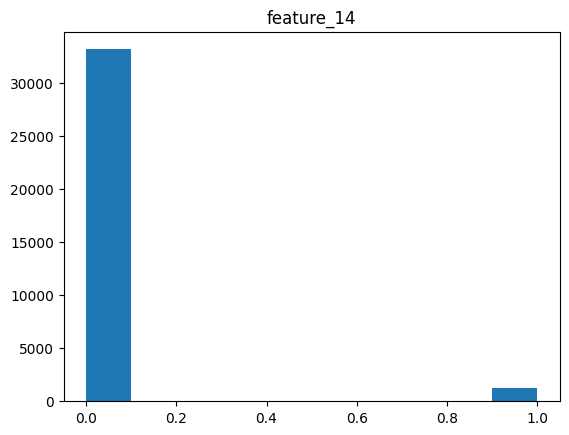

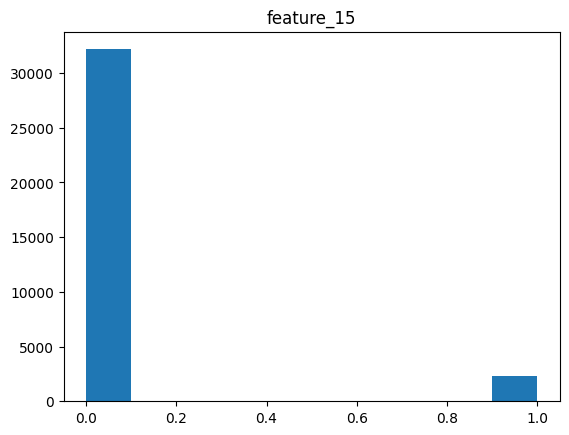

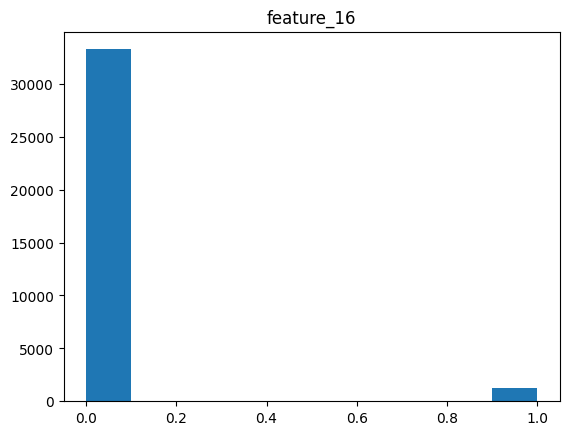

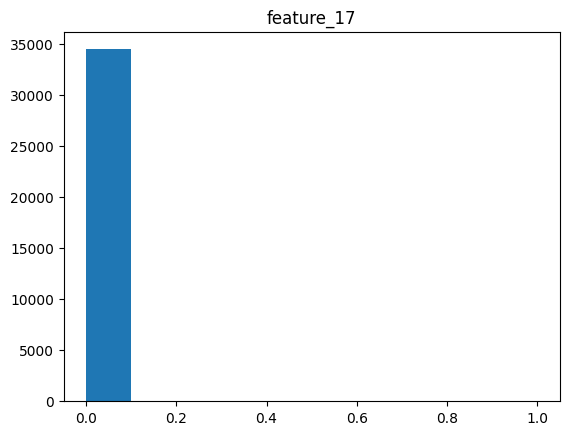

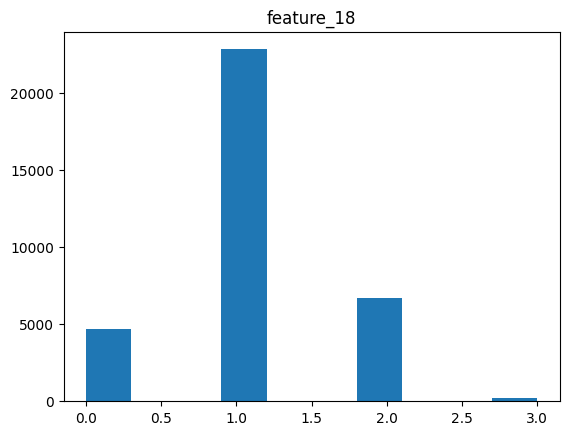

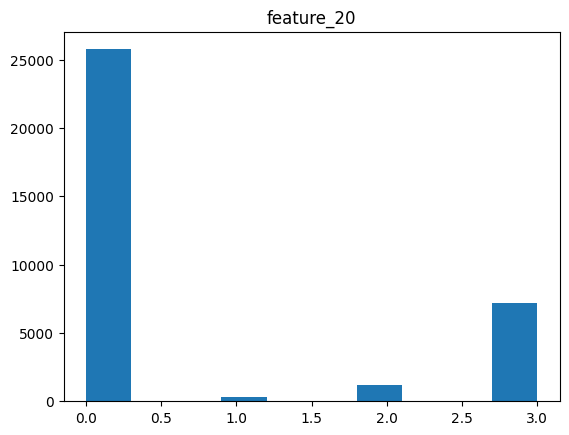

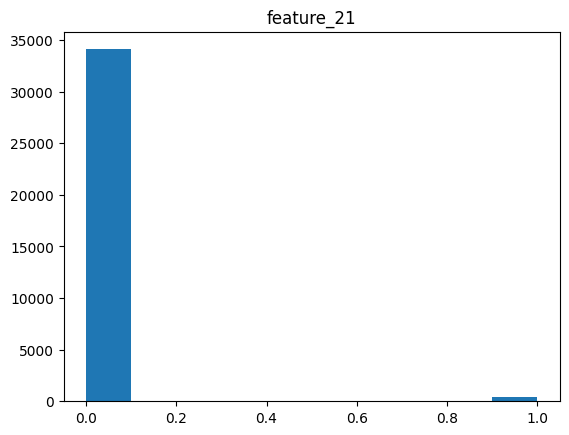

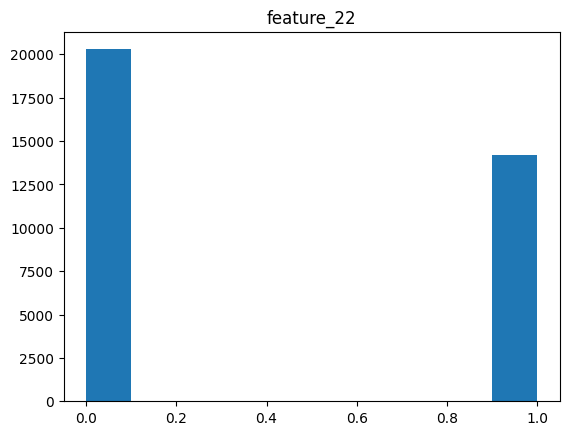

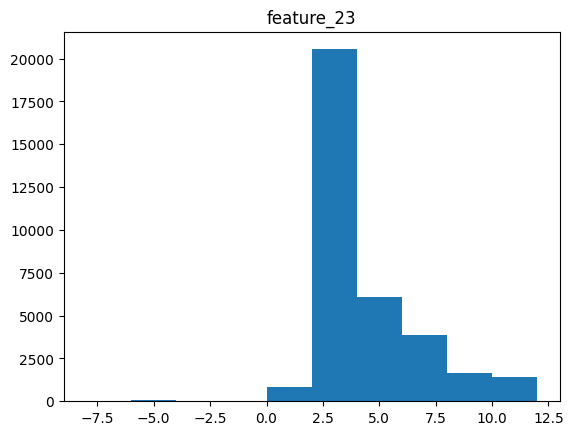

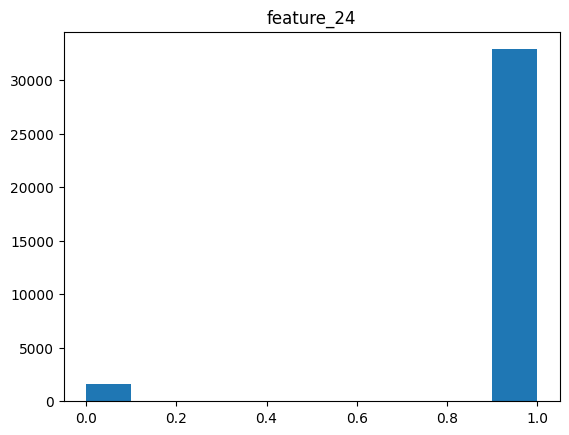

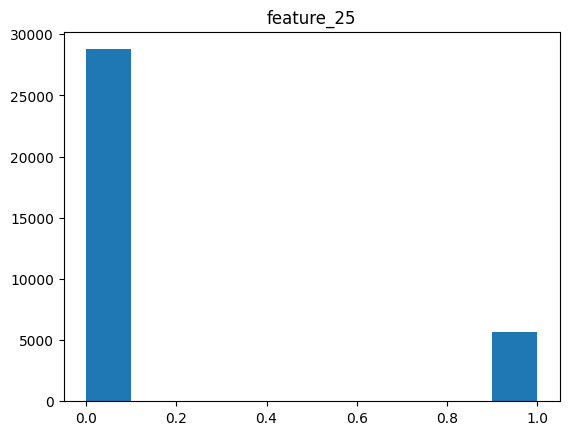

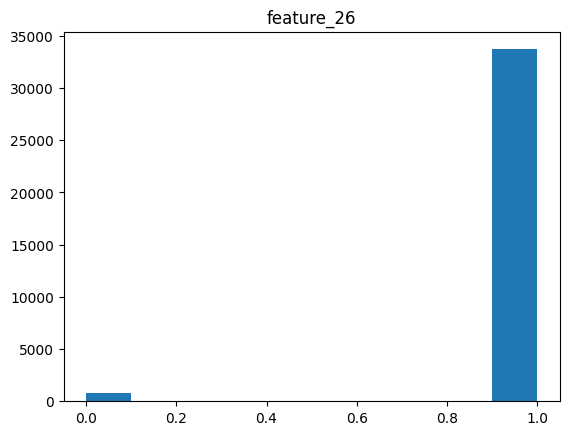

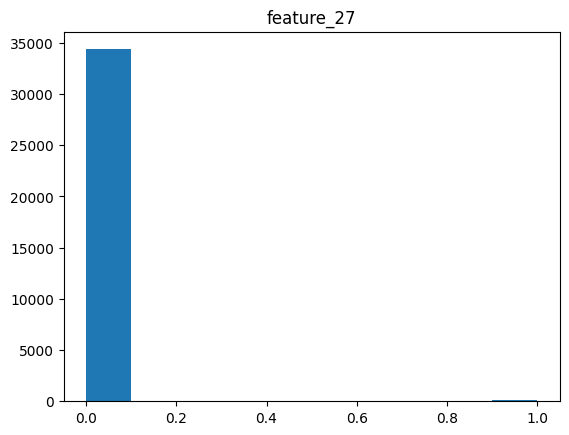

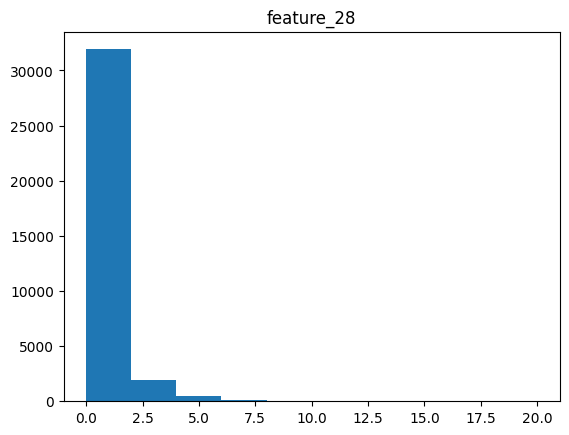

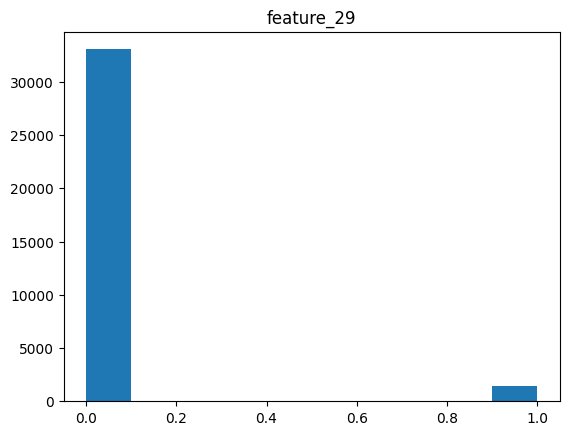

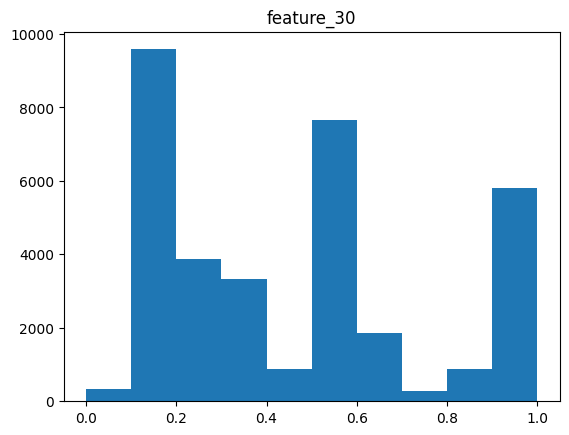

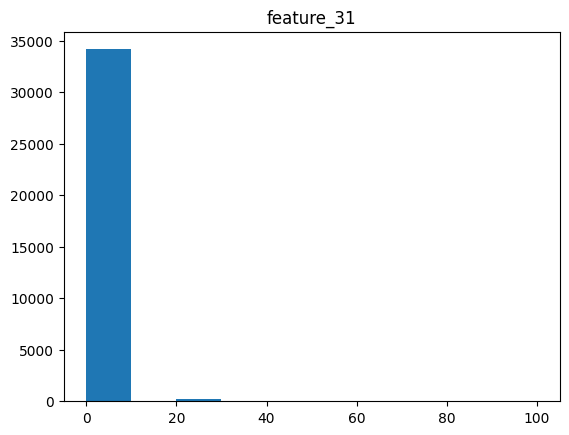

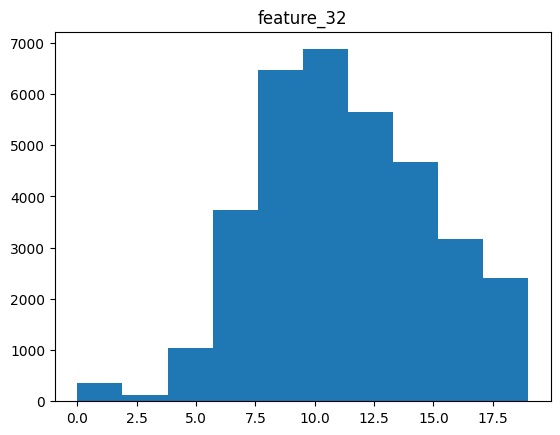

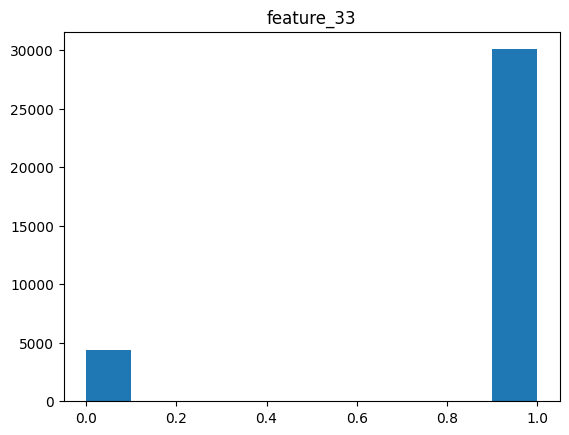

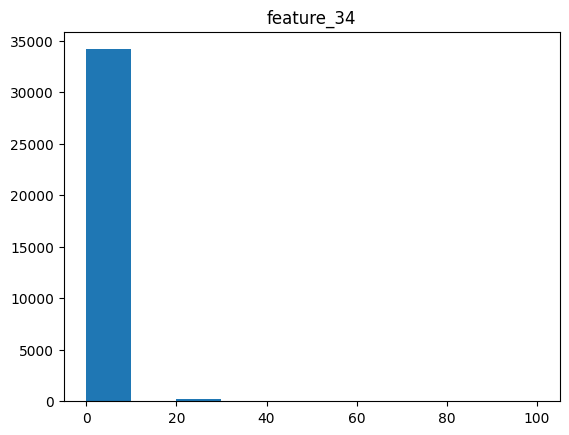

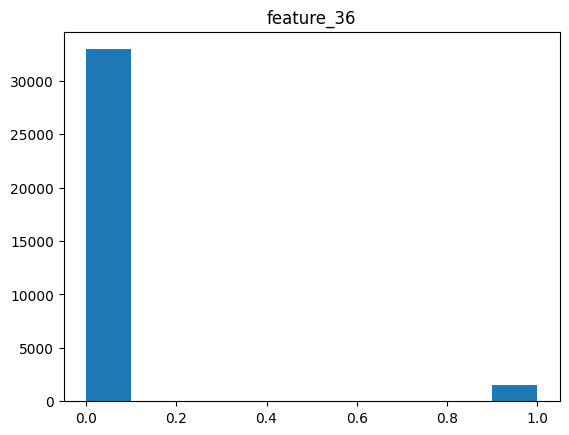

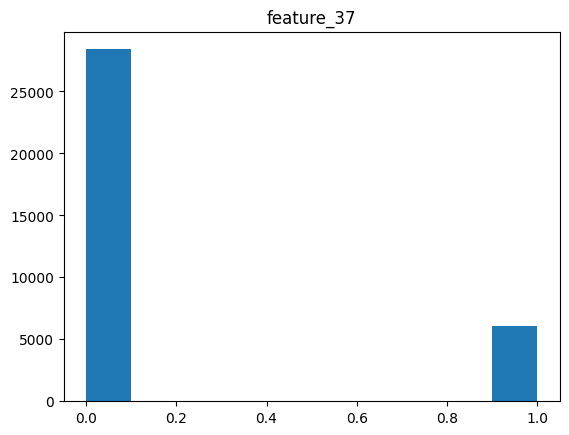

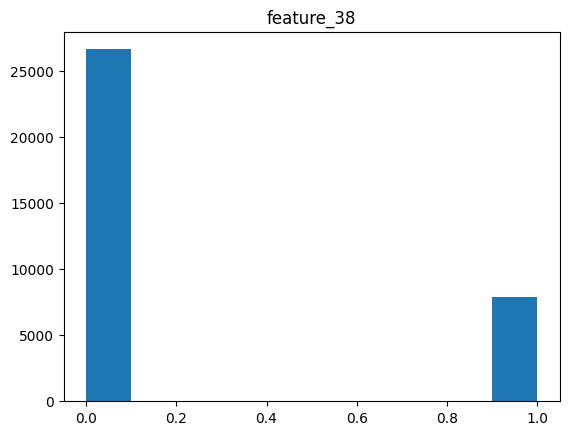

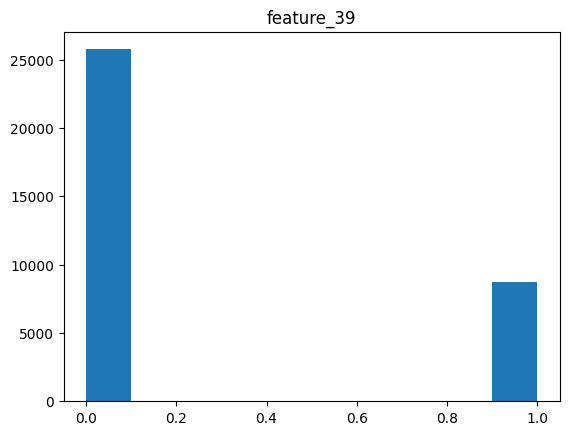

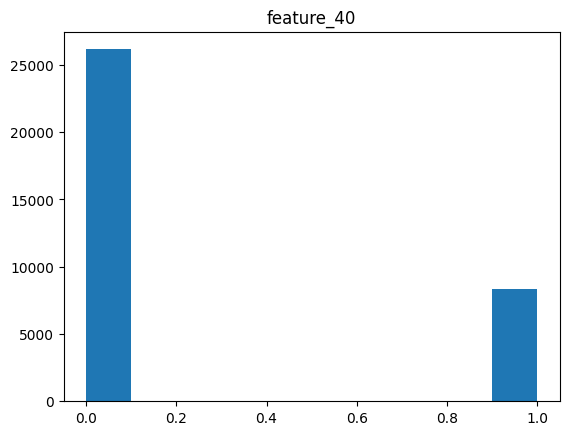

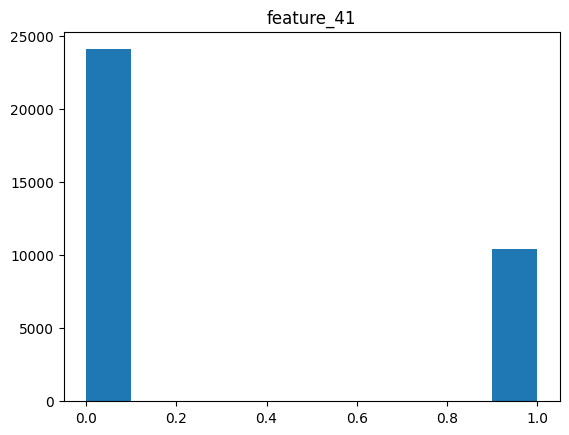

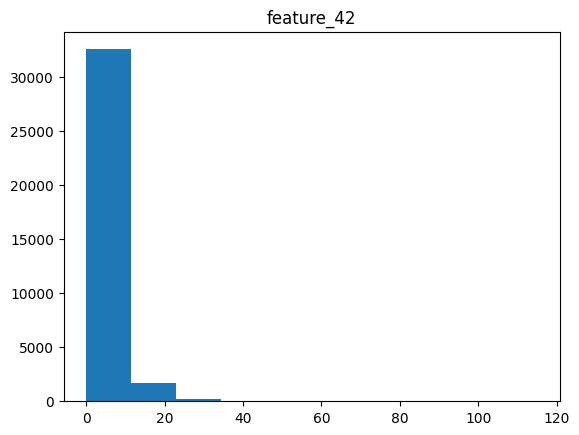

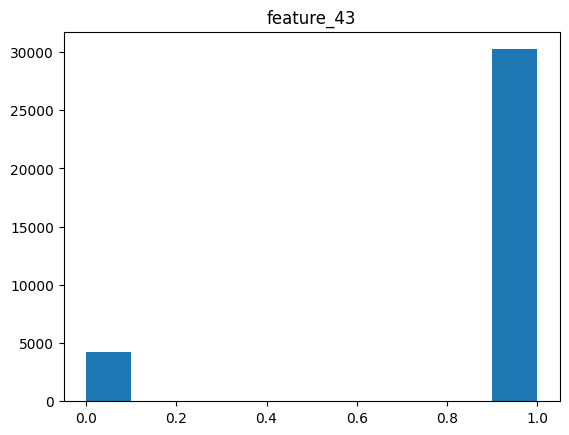

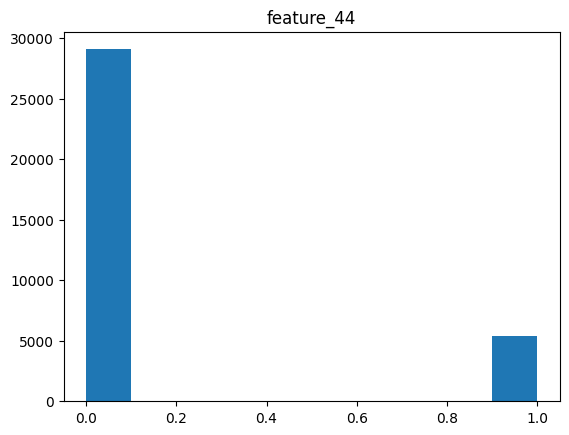

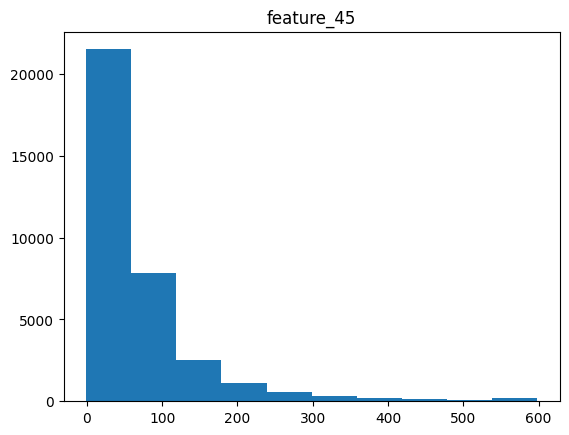

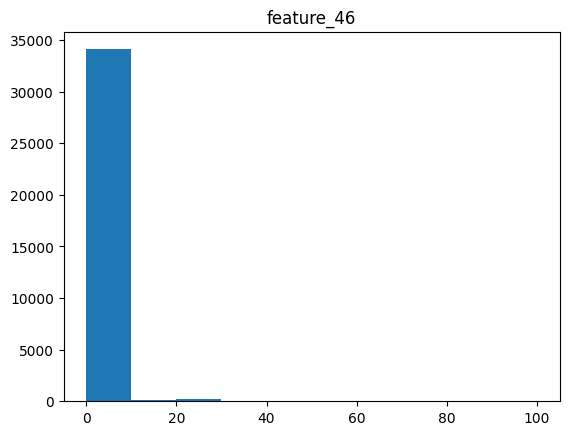

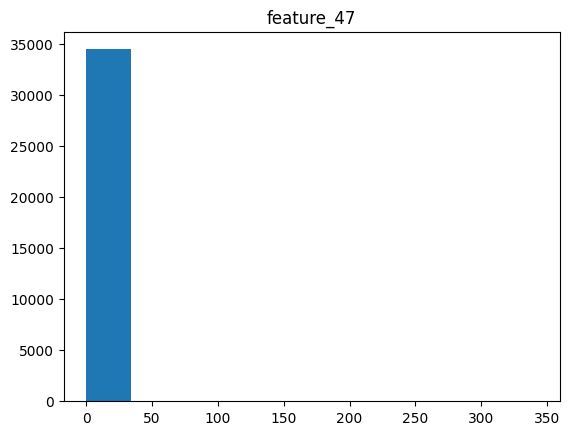

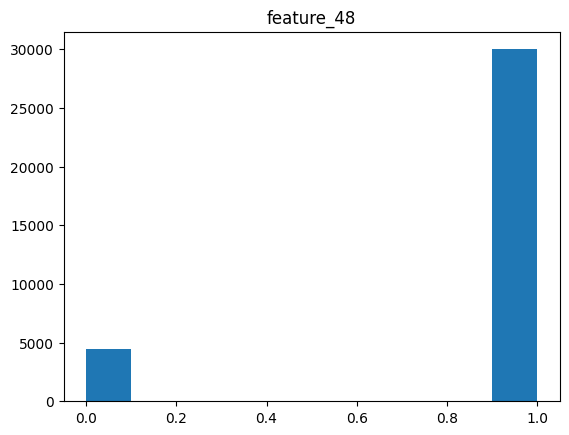

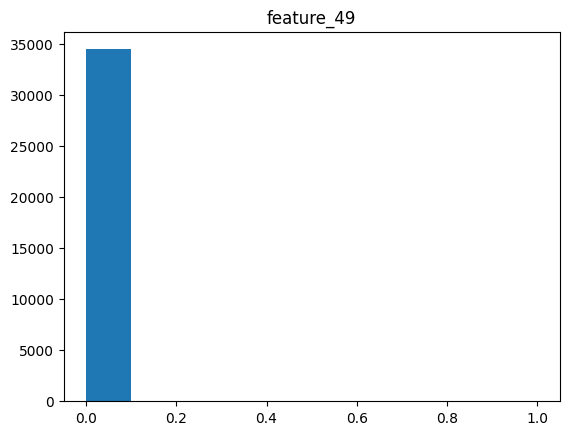

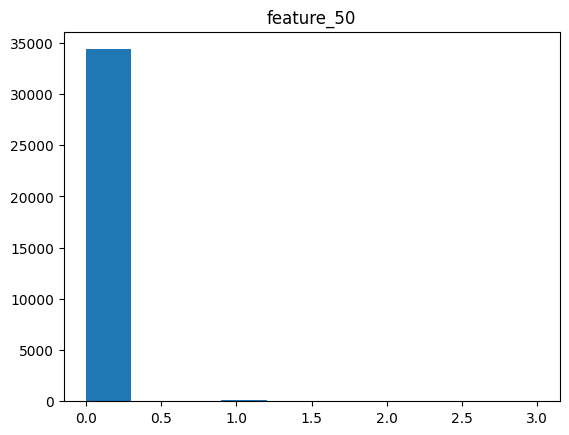

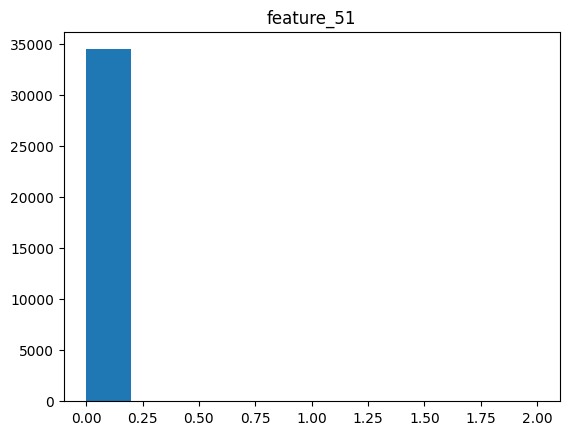

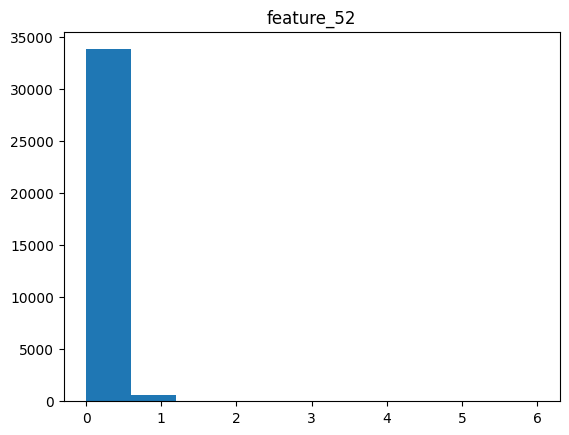

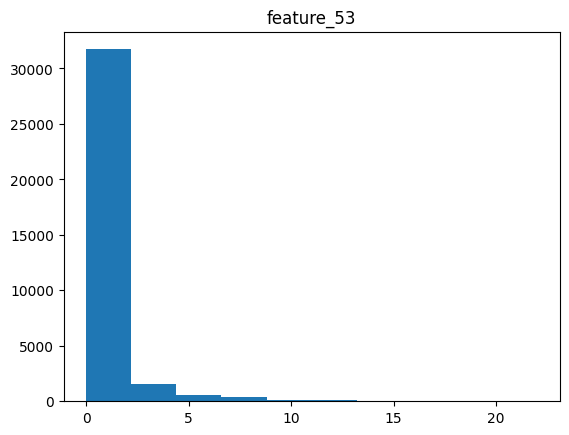

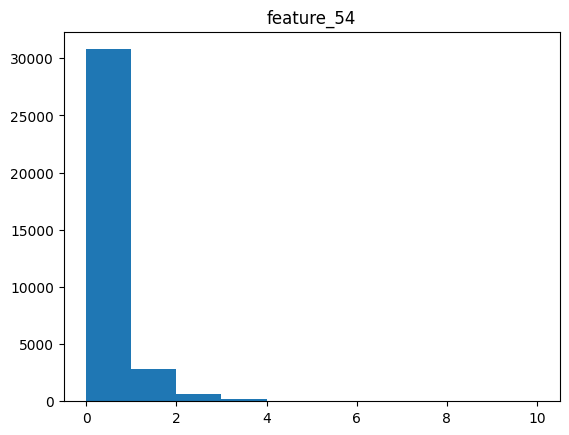

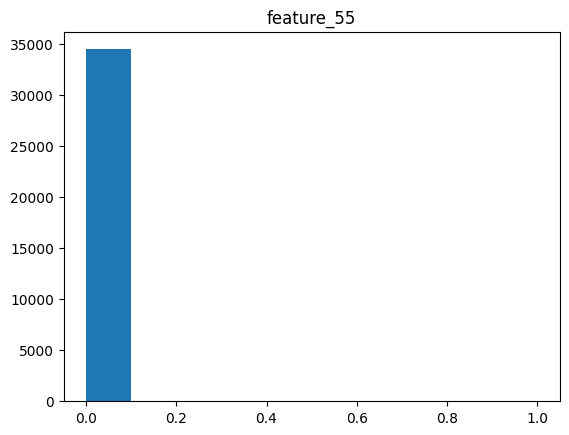

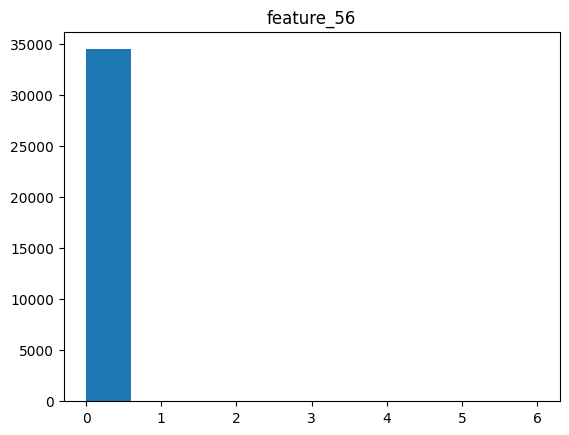

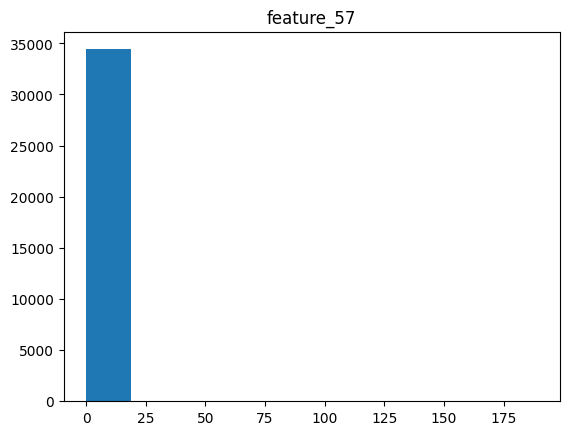

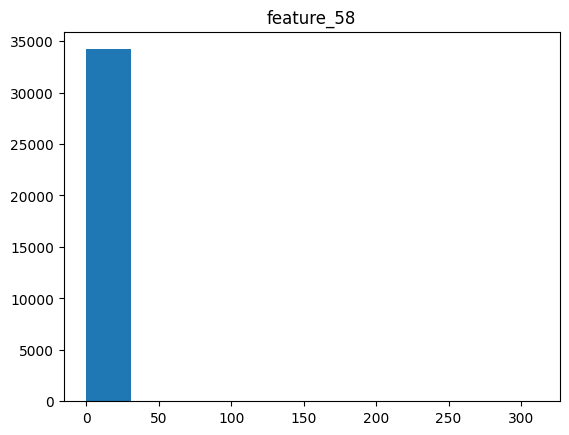

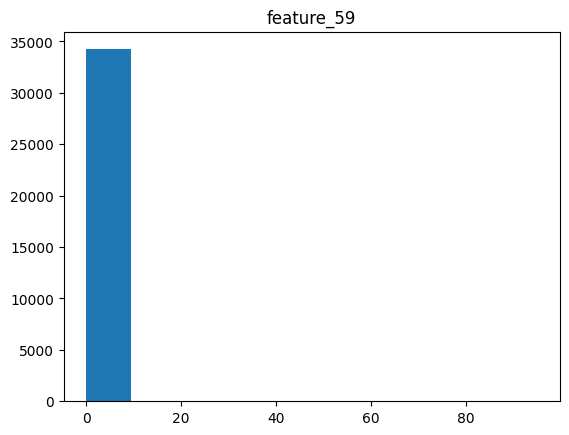

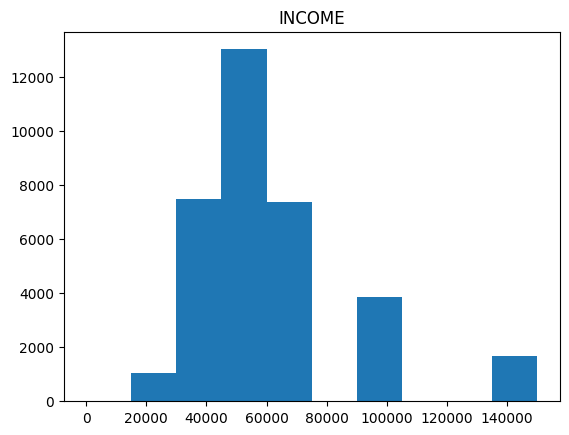

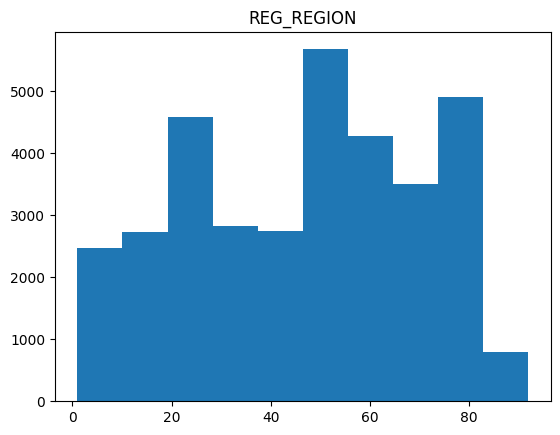

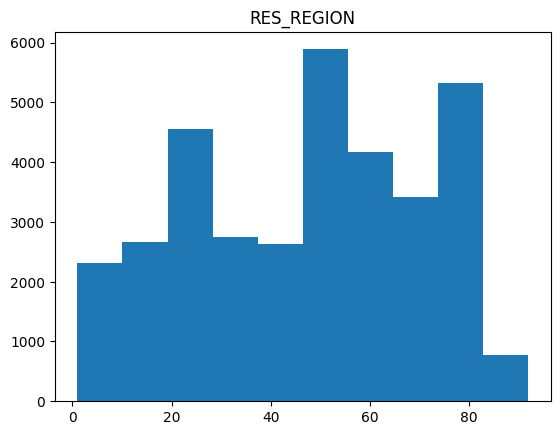

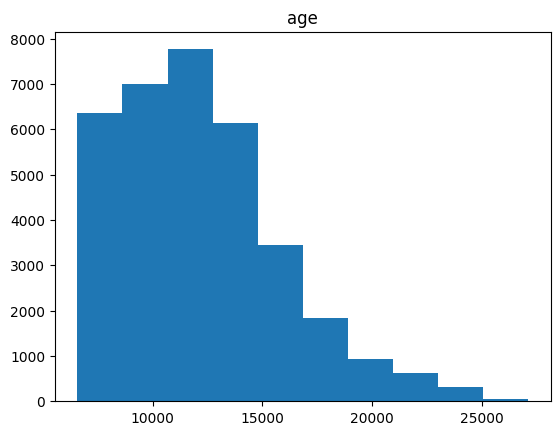

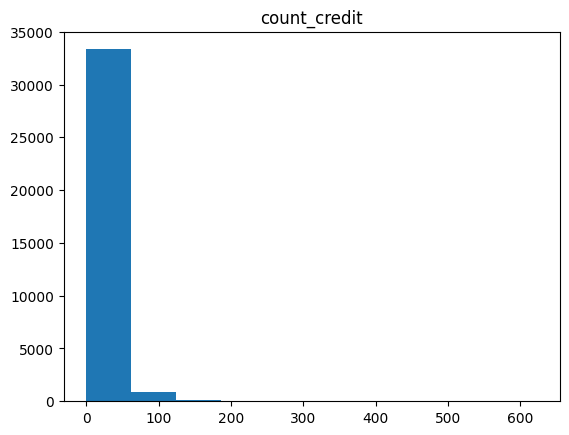

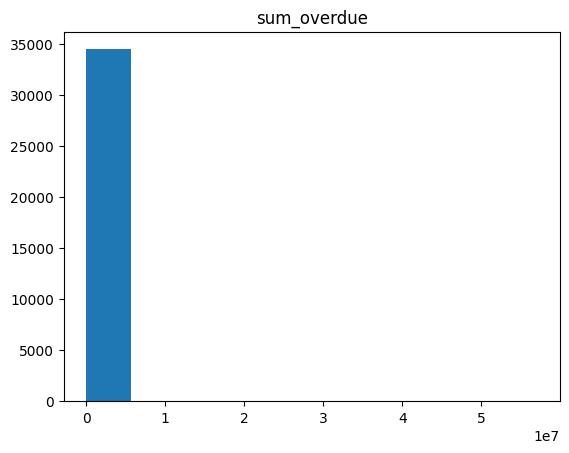

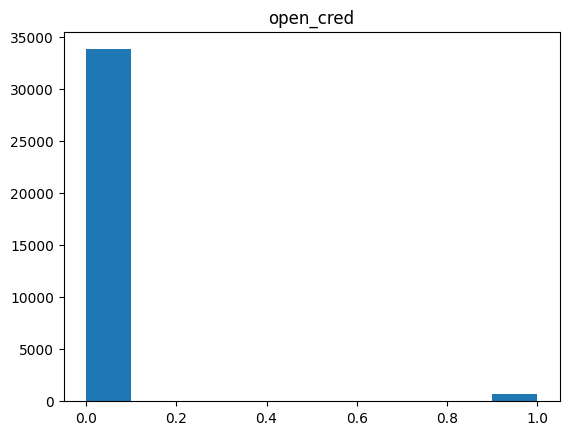

In [145]:
for i in data.drop(labels = ['ID','SAVE_STAMP', 'CARD_EXPIRY_DATE', 'pass_region_code', 'sim_region_code', 'ip_region_code'], axis = 1).columns:
  plt.title(i)
  plt.hist(data[i])
  plt.show()

В целевой фиче у нас явный дисбаланс. feature_0 - есть люди, которые подали очень много заявлений, но большинство все таки до 20 шт. feature_2 - так же есть достаточно большие выбросы, но большинство клиентов имеют небольшой размер истории в текущей сессии. feature_3 - большинство клиентов привязывают немного карт к своему устройству, но есть люди у которых этот показатель очень высокий. feature_4 - у большинства клиентов от 0 до 2 дополнительных городов. Очень много 0 в feature_10. Рассмотрим подробнее feature_12. Абсолютное большинство клиентов подают заявки с мобильного телефона, но есть и те кто пользуются планшетом, телевизором и прочими устройствами. В feature_17 почти всегда 0. feature_34 отражает количество дополнительных номеров клиента, у большинства до 20 телефонов.

Посмотрим корреляция признаков и целевой переменной.

In [148]:
phik_overview = data.drop(labels = ['SAVE_STAMP', 'CARD_EXPIRY_DATE'], axis = 1).phik_matrix()

interval columns not set, guessing: ['ID', 'AF1_TARGET', 'feature_0', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_11', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29', 'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34', 'feature_36', 'feature_37', 'feature_38', 'feature_39', 'feature_40', 'feature_41', 'feature_42', 'feature_43', 'feature_44', 'feature_45', 'feature_46', 'feature_47', 'feature_48', 'feature_49', 'feature_50', 'feature_51', 'feature_52', 'feature_53', 'feature_54', 'feature_55', 'feature_56', 'feature_57', 'feature_58', 'feature_59', 'INCOME', 'REG_REGION', 'RES_REGION', 'pass_region_code', 'sim_region_code', 'ip_region_code', 'age', 'count_credit', 'sum_overdue', 'open_cred']


Визуализируем нашу корреляцию

In [149]:
phik_overview
 .style
 .background_gradient(cmap='Blues', axis=1)

,ID,AF1_TARGET,feature_0,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,INCOME,REG_REGION,RES_REGION,pass_region_code,sim_region_code,ip_region_code,age,count_credit,sum_overdue,open_cred
ID,1.000000,0.358062,0.039686,0.085265,0.040614,0.038377,0.088773,0.069458,0.211781,0.052778,0.039213,0.000000,0.062589,0.135620,0.022668,0.057905,0.029797,0.059690,0.000000,0.060027,0.074001,0.149127,0.172455,0.042249,0.018297,0.052275,0.013284,0.000000,0.000000,0.057857,0.229625,0.038450,0.062822,0.222937,0.042073,0.078762,0.061604,0.094187,0.101002,0.074530,0.075108,0.082434,0.229198,0.029053,0.046989,0.040183,0.000000,0.220314,0.000000,0.000000,0.014567,0.019711,0.062204,0.004454,0.000000,0.000000,0.000000,0.046378,0.036323,0.124803,0.070072,0.066667,0.046638,0.048842,0.035242,0.097183,0.032895,0.000000,0.084516
AF1_TARGET,0.358062,1.000000,0.017783,0.122144,0.015342,0.053262,0.169382,0.065793,0.384763,0.279868,0.050221,0.027335,0.155048,0.292268,0.001652,0.124385,0.017530,0.071776,0.005003,0.110788,0.209294,0.191129,0.179456,0.171425,0.163397,0.049509,0.207120,0.019429,0.016101,0.125493,0.182956,0.023766,0.249458,0.451760,0.021018,0.118186,0.100245,0.196635,0.209237,0.105904,0.102265,0.118483,0.461962,0.000000,0.101534,0.028257,0.000000,0.445733,0.000000,0.004893,0.002934,0.000000,0.024016,0.017666,0.000000,0.003679,0.014707,0.000000,0.000000,0.123215,0.055583,0.044332,0.037097,0.084445,0.102025,0.208226,0.032875,0.000000,0.126027
feature_0,0.039686,0.017783,1.000000,0.139477,0.999992,0.032143,0.098046,0.037962,0.328814,0.000000,0.000000,0.000000,0.058220,0.197542,0.000000,0.604303,0.164801,0.613865,0.000000,0.057269,0.044071,0.094105,0.094107,0.198903,0.015934,0.082769,0.000000,0.000000,0.268079,0.574930,0.041199,0.999804,0.000000,0.313232,0.999951,0.026246,0.249535,0.061779,0.066636,0.206246,0.177201,0.062517,0.318679,0.041838,0.089619,0.998812,0.000000,0.309884,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.820939,0.822659,0.024252,0.016922,0.018288,0.028870,0.017785,0.142639,0.046804,0.039572,0.000000,0.018205
feature_2,0.085265,0.122144,0.139477,1.000000,0.139859,0.077073,0.061405,0.047624,0.149664,0.221160,0.085714,0.228927,0.145654,0.151788,0.000000,0.167077,0.067810,0.177137,0.000000,0.060855,0.078442,0.000000,0.037846,0.106481,0.098969,0.034833,0.150123,0.013864,0.065100,0.168070,0.114008,0.139639,0.171678,0.116014,0.139735,0.000000,0.106508,0.095181,0.103054,0.083770,0.130756,0.209207,0.119273,0.031820,0.065998,0.143324,0.000000,0.113092,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.124080,0.000000,0.131981,0.128306,0.123959,0.021918,0.027986,0.022852,0.025781,0.062917,0.056594,0.033675,0.019922,0.000000
feature_3,0.040614,0.015342,0.999992,0.139859,1.000000,0.031891,0.097306,0.037875,0.328241,0.000000,0.000000,0.000000,0.058321,0.197201,0.000000,0.603291,0.165073,0.614680,0.000000,0.057147,0.043966,0.093256,0.093921,0.199240,0.015858,0.082775,0.000000,0.000000,0.269316,0.573960,0.042177,0.999760,0.000000,0.312686,0.999926,0.026913,0.249065,0.061659,0.066508,0.206826,0.176872,0.062672,0.319344,0.042408,0.090187,0.998774,0.000000,0.309344,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.821112,0.822827,0.023680,0.019069,0.020257,0.029761,0.014320,0.142386,0.046178,0.039564,0.000000,0.018177
feature_4,0.038377,0.053262,0.032143,0.077073,0.031891,1.000000,0.055259,0.021595,0.076756,0.023784,0.

Как мы видим у нас есть мультиколлинеарность, поэтому не будем пробовать линейные модели, для них это будет большой проблемой.

# Обучение моделей

Разделим нашу выборку на трейн и тест, укажем на дисбаланс

In [153]:
train, test = train_test_split(data
                               ,test_size=0.30
                               ,random_state=42
                               ,stratify=data['AF1_TARGET'])

Выделим фичи, категориальные фичи для кэтбуста и таргет

In [154]:
X = ['ID', 'feature_0', 'feature_2', 'feature_3', 'feature_4',
       'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9',
       'feature_11', 'feature_13', 'feature_14',
       'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_20',
       'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_25',
       'feature_26', 'feature_27', 'feature_28', 'feature_29', 'feature_30',
       'feature_31', 'feature_32', 'feature_33', 'feature_34', 'feature_36',
       'feature_37', 'feature_38', 'feature_39', 'feature_40', 'feature_41',
       'feature_42', 'feature_43', 'feature_44', 'feature_45', 'feature_46',
       'feature_47', 'feature_48', 'feature_49', 'feature_50', 'feature_51',
       'feature_52', 'feature_53', 'feature_54', 'feature_55', 'feature_56',
       'feature_57', 'feature_58', 'feature_59', 'INCOME',
       'REG_REGION', 'RES_REGION',
       'age', 'count_credit', 'sum_overdue', 'open_cred', 'feature_10', 'feature_12']

cat_features = ['feature_10', 'feature_12']

y = ['AF1_TARGET']

Приступим к обучению. Для отладки модели будем использовать roc auc.

In [155]:
cat_best_roc_auc = 0
for estimators in range(100, 1101, 300):
    for rate in range(1, 10, 2):
        rate = rate/100
        model_cat = CatBoostClassifier(n_estimators=estimators,
                                   random_state=42,
                                   learning_rate = rate,
                                  loss_function= 'Logloss' ,
                                  verbose = 100,
                                  cat_features= cat_features).fit(train[X],train[y])

        roc_auc = cross_val_score(model_cat,
                                  train[X],
                                  train[y],
                                  scoring = 'roc_auc',
                                  cv = 5)

        roc_auc_cat = np.mean(roc_auc)

        if roc_auc_cat > cat_best_roc_auc:
            cat_best_roc_auc = roc_auc_cat
            best_model_cat = model_cat
            best_estimators = estimators
            best_rate = rate

print(f'''
Лучшая модель при количестве деревьев {best_estimators},
скоросью обучения {best_rate} с оценкой {cat_best_roc_auc}
''')

0:	learn: 0.6873623	total: 112ms	remaining: 11.1s
99:	learn: 0.4524959	total: 4.76s	remaining: 0us
0:	learn: 0.6874022	total: 30.7ms	remaining: 3.04s
99:	learn: 0.4544373	total: 2.37s	remaining: 0us
0:	learn: 0.6874535	total: 30.2ms	remaining: 2.99s
99:	learn: 0.4530377	total: 2.41s	remaining: 0us
0:	learn: 0.6875477	total: 28.3ms	remaining: 2.8s
99:	learn: 0.4510477	total: 2.35s	remaining: 0us
0:	learn: 0.6873322	total: 27.4ms	remaining: 2.71s
99:	learn: 0.4524666	total: 3.35s	remaining: 0us
0:	learn: 0.6872600	total: 52.3ms	remaining: 5.18s
99:	learn: 0.4521872	total: 4.17s	remaining: 0us
0:	learn: 0.6760165	total: 45.6ms	remaining: 4.51s
99:	learn: 0.3941890	total: 2.81s	remaining: 0us
0:	learn: 0.6761362	total: 26.2ms	remaining: 2.6s
99:	learn: 0.3947581	total: 2.37s	remaining: 0us
0:	learn: 0.6762864	total: 25.1ms	remaining: 2.49s
99:	learn: 0.3934882	total: 2.38s	remaining: 0us
0:	learn: 0.6765640	total: 25.3ms	remaining: 2.5s
99:	learn: 0.3923350	total: 3.45s	remaining: 0us
0:	l

Лучшая модель выдала оценку 0,81. Посмотрим что выдаст lgm. Предварительно сделае копию трейн и поменяем там тип данных.

In [156]:
train_lgm = train.copy()

X = ['ID', 'feature_0', 'feature_2', 'feature_3', 'feature_4',
       'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9',
       'feature_11', 'feature_13', 'feature_14',
       'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_20',
       'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_25',
       'feature_26', 'feature_27', 'feature_28', 'feature_29', 'feature_30',
       'feature_31', 'feature_32', 'feature_33', 'feature_34', 'feature_36',
       'feature_37', 'feature_38', 'feature_39', 'feature_40', 'feature_41',
       'feature_42', 'feature_43', 'feature_44', 'feature_45', 'feature_46',
       'feature_47', 'feature_48', 'feature_49', 'feature_50', 'feature_51',
       'feature_52', 'feature_53', 'feature_54', 'feature_55', 'feature_56',
       'feature_57', 'feature_58', 'feature_59', 'INCOME',
       'REG_REGION', 'RES_REGION',
       'age', 'count_credit', 'sum_overdue', 'open_cred', 'feature_10', 'feature_12']

categorical_feature = ['feature_10', 'feature_12']

y = ['AF1_TARGET']

for i in categorical_feature:
    train_lgm[i] = train_lgm[i].astype('category')

In [157]:
lgbm_best_roc_auc = 0
for estimators in range(100, 1701, 300):
    for rate in range(1, 10, 2):
        rate = rate/100
        model_lgbm = LGBMClassifier(n_estimators=estimators,
                                   random_state=42,
                                   learning_rate=rate,
                                   categorical_feature=categorical_feature).fit(train_lgm[X],train_lgm[y])

        roc_auc = cross_val_score(model_lgbm,
                                  train_lgm[X],
                                  train_lgm[y],
                                  scoring = 'roc_auc',
                                  cv = 5)

        roc_auc_lgbm = np.mean(roc_auc)

        if roc_auc_lgbm > lgbm_best_roc_auc:
            lgbm_best_roc_auc = roc_auc_lgbm
            best_model_lgbm = model_lgbm
            best_estimators = estimators
            best_rate = rate

print(f'''
Лучшая модель при количестве деревьев {best_estimators},
скоросью обучения {best_rate} с оценкой {lgbm_best_roc_auc}
''')

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 5312, number of negative: 18818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2301
[LightGBM] [Info] Number of data points in the train set: 24130, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220141 -> initscore=-1.264845
[LightGBM] [Info] Start training from score -1.264845


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2222
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2235
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 5312, number of negative: 18818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2301
[LightGBM] [Info] Number of data points in the train set: 24130, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220141 -> initscore=-1.264845
[LightGBM] [Info] Start training from score -1.264845


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2222
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018941 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2235
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 5312, number of negative: 18818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2301
[LightGBM] [Info] Number of data points in the train set: 24130, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220141 -> initscore=-1.264845
[LightGBM] [Info] Start training from score -1.264845


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2222
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2235
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 5312, number of negative: 18818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2301
[LightGBM] [Info] Number of data points in the train set: 24130, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220141 -> initscore=-1.264845
[LightGBM] [Info] Start training from score -1.264845


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2222
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015810 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2235
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 5312, number of negative: 18818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2301
[LightGBM] [Info] Number of data points in the train set: 24130, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220141 -> initscore=-1.264845
[LightGBM] [Info] Start training from score -1.264845


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2222
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015676 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2235
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 5312, number of negative: 18818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2301
[LightGBM] [Info] Number of data points in the train set: 24130, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220141 -> initscore=-1.264845
[LightGBM] [Info] Start training from score -1.264845


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2222
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2235
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 5312, number of negative: 18818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2301
[LightGBM] [Info] Number of data points in the train set: 24130, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220141 -> initscore=-1.264845
[LightGBM] [Info] Start training from score -1.264845


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2222
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2235
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 5312, number of negative: 18818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2301
[LightGBM] [Info] Number of data points in the train set: 24130, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220141 -> initscore=-1.264845
[LightGBM] [Info] Start training from score -1.264845


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010904 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2222
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011848 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2235
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 5312, number of negative: 18818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2301
[LightGBM] [Info] Number of data points in the train set: 24130, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220141 -> initscore=-1.264845
[LightGBM] [Info] Start training from score -1.264845


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2222
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010837 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2235
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 5312, number of negative: 18818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2301
[LightGBM] [Info] Number of data points in the train set: 24130, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220141 -> initscore=-1.264845
[LightGBM] [Info] Start training from score -1.264845


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011071 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2222
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010945 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2235
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 5312, number of negative: 18818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2301
[LightGBM] [Info] Number of data points in the train set: 24130, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220141 -> initscore=-1.264845
[LightGBM] [Info] Start training from score -1.264845


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2222
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2235
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 5312, number of negative: 18818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2301
[LightGBM] [Info] Number of data points in the train set: 24130, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220141 -> initscore=-1.264845
[LightGBM] [Info] Start training from score -1.264845


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011391 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2222
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010823 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010975 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2235
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 5312, number of negative: 18818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2301
[LightGBM] [Info] Number of data points in the train set: 24130, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220141 -> initscore=-1.264845
[LightGBM] [Info] Start training from score -1.264845


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2222
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2235
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 5312, number of negative: 18818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013900 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2301
[LightGBM] [Info] Number of data points in the train set: 24130, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220141 -> initscore=-1.264845
[LightGBM] [Info] Start training from score -1.264845


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2222
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2235
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 5312, number of negative: 18818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2301
[LightGBM] [Info] Number of data points in the train set: 24130, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220141 -> initscore=-1.264845
[LightGBM] [Info] Start training from score -1.264845


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015733 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2222
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2235
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 5312, number of negative: 18818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2301
[LightGBM] [Info] Number of data points in the train set: 24130, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220141 -> initscore=-1.264845
[LightGBM] [Info] Start training from score -1.264845


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010943 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2222
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010935 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2235
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 5312, number of negative: 18818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2301
[LightGBM] [Info] Number of data points in the train set: 24130, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220141 -> initscore=-1.264845
[LightGBM] [Info] Start training from score -1.264845


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010826 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2222
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014834 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2235
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 5312, number of negative: 18818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2301
[LightGBM] [Info] Number of data points in the train set: 24130, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220141 -> initscore=-1.264845
[LightGBM] [Info] Start training from score -1.264845


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2222
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2235
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 5312, number of negative: 18818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2301
[LightGBM] [Info] Number of data points in the train set: 24130, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220141 -> initscore=-1.264845
[LightGBM] [Info] Start training from score -1.264845


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2222
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010972 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2235
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 5312, number of negative: 18818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2301
[LightGBM] [Info] Number of data points in the train set: 24130, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220141 -> initscore=-1.264845
[LightGBM] [Info] Start training from score -1.264845


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2222
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2235
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 5312, number of negative: 18818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2301
[LightGBM] [Info] Number of data points in the train set: 24130, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220141 -> initscore=-1.264845
[LightGBM] [Info] Start training from score -1.264845


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2222
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2235
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 5312, number of negative: 18818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2301
[LightGBM] [Info] Number of data points in the train set: 24130, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220141 -> initscore=-1.264845
[LightGBM] [Info] Start training from score -1.264845


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2222
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2235
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 5312, number of negative: 18818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013845 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2301
[LightGBM] [Info] Number of data points in the train set: 24130, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220141 -> initscore=-1.264845
[LightGBM] [Info] Start training from score -1.264845


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2222
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2235
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 5312, number of negative: 18818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2301
[LightGBM] [Info] Number of data points in the train set: 24130, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220141 -> initscore=-1.264845
[LightGBM] [Info] Start training from score -1.264845


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2222
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2235
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 5312, number of negative: 18818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013772 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2301
[LightGBM] [Info] Number of data points in the train set: 24130, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220141 -> initscore=-1.264845
[LightGBM] [Info] Start training from score -1.264845


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2222
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2235
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 5312, number of negative: 18818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2301
[LightGBM] [Info] Number of data points in the train set: 24130, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220141 -> initscore=-1.264845
[LightGBM] [Info] Start training from score -1.264845


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2222
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2235
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 5312, number of negative: 18818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2301
[LightGBM] [Info] Number of data points in the train set: 24130, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220141 -> initscore=-1.264845
[LightGBM] [Info] Start training from score -1.264845


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2222
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2235
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 5312, number of negative: 18818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2301
[LightGBM] [Info] Number of data points in the train set: 24130, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220141 -> initscore=-1.264845
[LightGBM] [Info] Start training from score -1.264845


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2222
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2235
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 5312, number of negative: 18818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2301
[LightGBM] [Info] Number of data points in the train set: 24130, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220141 -> initscore=-1.264845
[LightGBM] [Info] Start training from score -1.264845


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2222
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2235
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 5312, number of negative: 18818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2301
[LightGBM] [Info] Number of data points in the train set: 24130, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220141 -> initscore=-1.264845
[LightGBM] [Info] Start training from score -1.264845


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4249, number of negative: 15055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011014 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2222
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220110 -> initscore=-1.265027
[LightGBM] [Info] Start training from score -1.265027


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012984 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden

[LightGBM] [Warning] categorical_feature is set=feature_10,feature_12, categorical_column=63,64 will be ignored. Current value: categorical_feature=feature_10,feature_12
[LightGBM] [Info] Number of positive: 4250, number of negative: 15054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2235
[LightGBM] [Info] Number of data points in the train set: 19304, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220162 -> initscore=-1.264725
[LightGBM] [Info] Start training from score -1.264725

Лучшая модель при количестве деревьев 700,
скоросью обучения 0.01 с оценкой 0.807928458109388



У lgm качество немного хуже, выведем в небольшую таблицу для наглядности

In [166]:
results = {
    'Model' : ['CatBoostClassifier', 'LGBMClassifier'],
    'roc_auc' :pd.Series([cat_best_roc_auc, lgbm_best_roc_auc])
    }
display(pd.DataFrame(results))

,Model,roc_auc
0,CatBoostClassifier,0.811578
1,LGBMClassifier,0.807928


Таким образом, мы заканчиваем этап обучения моделей. На нем мы: выделили целевую фичу, разделили выборку на обучающую и тестовую, обработали категориальные признаки и попробовали 2 модели машинного обучения, на лучшей из которых проверим тестовые данны.

#Проверка модели на тестовых данных

Посмотрим что выдаст кэтбуст на тестовых данных, сразу визуализируем метрику качества

AUC-ROC: 0.8137719413602862


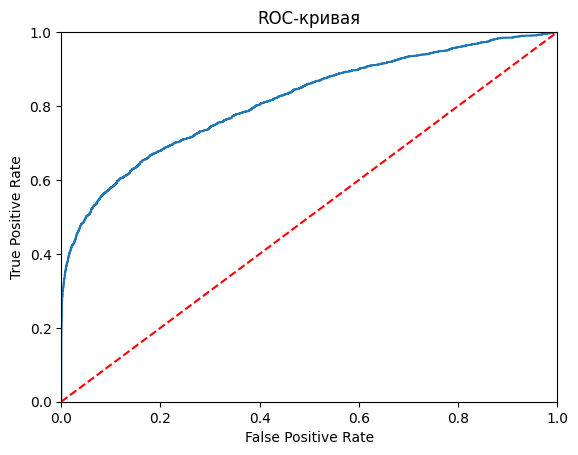

In [159]:
probabilities_cat = best_model_cat.predict_proba(test[X])
probabilities_one_cat = probabilities_cat[:,1]
fpr_cat,tpr_cat,thresholds = roc_curve(test[y],probabilities_one_cat)

auc_roc_cat = roc_auc_score(test[y],probabilities_one_cat)

print('AUC-ROC:', auc_roc_cat)

plt.figure()
plt.plot(fpr_cat, tpr_cat)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()

# Вывод

Таким образом, мы проанализировали датасет с данными клиентов, подающих заявки на кредит. Для начала мы предобработали наши данные: проверили наличие дубликатов, обработали пропуски, добавили новые столбцы, характеризующие наших клиентов. Так как у нас было несколько датасетов, объединили их в один. На следущем шаге мы исследовали датасет. Посмотрели возраст наших клиентов, сколько кредитов они брали до этого. Узнали самое популярное устройство и что порой люди подают на кредит с TV. На этапе обучения моделей мы проверили 2 модели и выбрали наилучшую. Это оказалась CatBoostClassifier, модель показала наилучший AUC-ROC. После мы посмотрели результат работы на тестовых данных.